In [10]:
import pandas as pd
import os
import glob
import time

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot
from bokeh.io import export_svg, output_notebook, install_notebook_hook, notebook
import numpy as np
import re
import seaborn as sb

from tqdm import tqdm

import json

import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [11]:
PALLETTE = [
    (230/255.0, 60/255.0, 49/255.0),
    (48/255.0, 72/255.0, 125/255.0),
    (0/255.0, 152/255.0, 123/255.0),
    (245/255.0, 143/255.0, 116/255.0),
    (57/255.0, 179/255.0, 207/255.0),
]

In [12]:
def timems():
    return round(time.time() * 1000)

In [13]:
def parse_fasta(protein_fasta):
    id = protein_fasta.split("\n")[0]
    sequence = ''.join(protein_fasta.split("\n")[1:])
    return (id, sequence)

def merge_windows(wins):
    a = [wins[0]]
    for i in range(len(wins)-1):
        prev = a[len(a)-1]
        next = wins[i+1]
        if prev[1] + 1 >= next[0]:
            a[len(a)-1] = (a[len(a)-1][0], next[1])
        else:
            a.append(next)
    return a

def read_identity(path, ref):
    df = pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,1,2,3,4], header=None)
    df.columns = ["seq1", "seq2", "identity", "nid", "denom"]
    idx1 = df["seq1"].str.contains(ref)
    idx2 = df["seq2"].str.contains(ref)
    df = df[idx1 | idx2]
    idx = (df["seq2"].str.contains(ref))
    # put all references to the seq2 column
    df.loc[idx, ["seq1", "seq2"]] = df.loc[idx, ["seq2", "seq1"]].values
    df["seq2"] = df["seq2"].map(lambda x: x.split("|")[1])
    df = df.drop(columns=["seq1"]).set_index("seq2")
    return dict(zip(df.index, df.identity))

def read_stride(path):
    data = []
    with open(path, "r") as f:
        for line in f.readlines():
            if line[:3] == "ASG":
                data.append(re.split("\s+", line)[6])
    return data

def read_safe_sequences(safety_path, stride_path):
    safe_sequences = []
    raw = ""
    with open(safety_path, "r") as f:
        raw = ("\n" + f.read()).split("\n>")[1:]
    ref_accession = raw[0].split("\n")[0].split(" ")[0].strip().split("|")[1]
    ref = raw[0].split("\n")[1].strip()
    
    for data in raw[1:]:
        splitted = data.split("\n")
        accession = splitted[0].split(" ")[0].split("|")[1]
        seq = splitted[1].strip()
        rwindows = []
        swindows = []
        for line in splitted[3:]:
            ends = line.split()
            if len(ends) != 4:
                continue
            rwindows.append((int(ends[0]), int(ends[1])))
            swindows.append((int(ends[2]), int(ends[3])))
        safe_sequences.append(SafeSequence(accession, seq, rwindows, merge_windows(rwindows), swindows, merge_windows(swindows), stride_path))
        
    return (ref, ref_accession, safe_sequences)

In [14]:
def get_colors(seqs, longest):
    """make colors for bases in sequence"""
    colors = []
    for ss in seqs:
        colors += ss.get_stride_colors(longest)
        colors += ss.get_safety_window_colors(longest)
    colors += ["white" for i in range(longest)]
    return colors

def get_columns(ref, seqs, longest):
    text = ""
    for ss in seqs:
        s = ss.sequence + (" " * (longest - len(ss.sequence)))
        text += ss.get_strides() + (" " * (longest - len(ss.sequence)))
        text += s
    text += ref + (" " * (longest - len(ref)))
    return list(text)

In [15]:
clrs = ["steelblue"]
flex = ["Coil", "Strand", "Turn"]
acids = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V", "U", "O"]

class SafeSequence():
    def __init__(self, accession, sequence, raw_ref_windows, ref_windows, raw_seq_windows, seq_windows, stride_path):
        self.accession = accession
        self.sequence = sequence
        self.identity = 0.0
        self.raw_ref_windows = raw_ref_windows
        self.raw_seq_windows = raw_seq_windows
        self.ref_windows = ref_windows
        self.seq_windows = seq_windows
        self.safe_bases = 0
        self.stable_bases = 0
        self.strides = self.read_strides(stride_path)
        self.TP, self.TN, self.FP, self.FN = 0,0,0,0
        self.calculate_hits()
        if self.TP + self.FP == 0:
            # print(f"{self.TP}, {self.FP}, {self.TN}, {self.FN}")
            self.precision = 0
        else: 
            self.precision = self.TP / max(self.TP + self.FP, 1)
        if self.TP + self.FN == 0:
            # print(f"{self.TP}, {self.FP}, {self.TN}, {self.FN}")
            self.recall = 0
        else:
            self.recall = self.TP / max(self.TP + self.FN, 1)

        # base distribution in the sequence
        # self.safe_distribution = {}
        # self.non_safe_distribution = {}
        # self.distribution = {}
        # for acid in acids:
        #     self.distribution[acid] = 0
        #     self.safe_distribution[acid] = 0
        #     self.non_safe_distribution[acid] = 0
        # self.calculate_distributions()

    def calculate_hits(self):
        for i in range(len(self.sequence)):
            safe = self.is_safe(i)
            stable = self.is_stable(i)
            self.safe_bases += safe
            self.stable_bases += stable
            self.TP += (safe and stable)
            self.TN += (not safe and not stable)
            self.FP += (safe and not stable)
            self.FN += (not safe and stable)
        assert self.TP + self.TN + self.FP + self.FN == len(self.sequence), f"Hits do not match"

    def calculate_distributions(self):
        for i in range(len(self.sequence)):
            safe = self.is_safe(i)
            aa = self.sequence[i]
            self.distribution[aa] += 1
            self.safe_distribution[aa] += safe
            self.non_safe_distribution[aa] += not safe

    def is_safe(self, i):
        for window in self.seq_windows:
            start = window[0]
            end = window[1]
            if i >= start and i <= end:
                return True
        return False

    def is_stable(self, i):
        return self.strides[i] not in flex

    def get_safety_window_colors(self, longest):
        colors = ["white"] * longest
        clr = 0
        for window in self.seq_windows:
            start = window[0]
            end = window[1]
            for i in range(start, end):
                colors[i] = clrs[clr % len(clrs)]
            
            clr += 1
        return colors

    def get_stride_colors(self, longest):
        colors = []
        for stride in self.strides:
            if stride not in flex:
                colors.append("palegreen")
            else:
                colors.append("white")
        
        return colors + (["white"] * (longest - len(self.sequence)))

    def get_strides(self):
        return "".join([stride[0] for stride in self.strides])

    def read_strides(self, path):
        return read_stride(f"{path}/{self.accession}.out")

class Cluster():
    def __init__(self, safe_path, stride_path, id_path):
        self.ref_seq, self.ref_accession, self.sequences = read_safe_sequences(safe_path, stride_path)
        identity_df = read_identity(id_path, self.ref_accession)
        for ss in self.sequences:
            ss.identity = identity_df[ss.accession]
        del(identity_df)
        self.precision, self.recall = self.get_precision_recall()
        self.avg_safe_coverage = self.get_safe_coverage()
        self.avg_stable_coverage = self.get_stable_coverage()

    def get_precision_recall(self):
        tp, fp, tn, fn = 0,0,0,0
        for ss in self.sequences:
            tp += ss.TP
            fp += ss.FP
            tn += ss.TN
            fn += ss.FN
        return (tp/(tp+fp), tp/(tp+fn))

    def get_safe_coverage(self):
        coverage = 0.0
        for ss in self.sequences:
            coverage += (ss.safe_bases / len(ss.sequence))
        coverage /= len(self.sequences)
        return coverage

    def get_stable_coverage(self):
        coverage = 0.0
        for ss in self.sequences:
            coverage += (ss.stable_bases / len(ss.sequence))
        coverage /= len(self.sequences)
        return coverage

    def plot_windows(self):
        longest = len(self.ref_seq)
        for ss in self.sequences:
            longest = max(len(ss.sequence), longest)

        text = get_columns(self.ref_seq, self.sequences, longest)
        colors = get_colors(self.sequences, longest)
        cols = longest
        rows = len(self.sequences)*2+1
        x = np.arange(1, cols + 1)
        y = np.arange(0, rows, 1)
        xx, yy = np.meshgrid(x, y)
        gx = xx.ravel()
        gy = yy.flatten()
        recty = gy + 0.5
        d = dict(x=gx, y=gy, recty=recty, text=text, colors=colors)
        source = ColumnDataSource(d)
        plot_height = rows * 15
        plot_width = longest * 15
        x_range = Range1d(0, cols + 1, bounds='auto')

        rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors", line_color=None, fill_alpha=0.8)
        glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black", text_font_size="4pt")
        
        p = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=x_range, y_range=(0,rows),
                min_border=0, toolbar_location='below')
        p.add_glyph(source, rects)
        p.add_glyph(source, glyph)    
        p = gridplot([[p]])

        return p

In [16]:
def get_clusters(work_dir, alpha, delta):
    safety_files = sorted(glob.glob(os.path.join(work_dir, f"safety.a{alpha}.d{delta}", "*.out")))
    identity_files = sorted(glob.glob(os.path.join(work_dir, "id", "*.out")))
    stride_files = sorted(filter(os.path.isdir, glob.glob(os.path.join(work_dir, "stride", "*"))))
    
    assert len(safety_files) == len(stride_files) and len(identity_files) == len(safety_files), f"Not proper file count {len(safety_files)} {len(identity_files)} {len(stride_files)}"
    
    z = list(zip(safety_files, stride_files, identity_files))
    clusters = []
    for file in tqdm(z):
        clusters.append(Cluster(file[0], file[1], file[2]))

    return clusters

In [17]:
def to_df(clusters):
    identity = []
    refs = []
    ids = []
    tps = []
    fps = []
    tns = []
    fns = []
    r_windows = []
    s_windows = []
    for cluster in clusters:
        for ss in cluster.sequences:
            refs.append(cluster.ref_accession)
            ids.append(ss.accession)
            identity.append(ss.identity)
            tps.append(ss.TP)
            tns.append(ss.TN)
            fns.append(ss.FN)
            fps.append(ss.FP)
            r_windows.append(json.dumps(ss.raw_ref_windows))
            s_windows.append(json.dumps(ss.raw_seq_windows))
    return pd.DataFrame(
        data={"ref":refs, "id":ids, "identity":identity,
        "TP":tps, "FP":fps, "TN": tns, "FN": fns,
        "r_windows": r_windows, "s_windows": s_windows})  
 
def get_all_clusters(path, alphas, deltas):
    groups = {}
    for alpha in alphas:
        for delta in deltas:
            print(f"a{alpha}.d{delta}")
            df_path = os.path.join(path, "df", f"a{alpha}.d{delta}.csv")
            if os.path.isfile(df_path):
                groups[(alpha, delta)] = pd.read_csv(df_path, index_col=0)
            else:
                groups[(alpha, delta)] = to_df(get_clusters(path, alpha, delta))
                groups[(alpha, delta)].to_csv(df_path)
            
            groups[(alpha, delta)]["precision"] = groups[(alpha, delta)]["TP"]/(groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FP"])
            groups[(alpha, delta)]["recall"] = groups[(alpha, delta)]["TP"]/(groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FN"])
            groups[(alpha, delta)]["safe_coverage"] = (groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FP"]) / (groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FP"] + groups[(alpha, delta)]["TN"] + groups[(alpha, delta)]["FN"])
            groups[(alpha, delta)]["stable_coverage"] = (groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FN"]) / (groups[(alpha, delta)]["TP"] + groups[(alpha, delta)]["FP"] + groups[(alpha, delta)]["TN"] + groups[(alpha, delta)]["FN"])
            groups[(alpha, delta)]["F1-score"] = (2 * groups[(alpha, delta)]["precision"] * groups[(alpha, delta)]["recall"])/(groups[(alpha, delta)]["precision"] + groups[(alpha, delta)]["recall"])
            #groups[(alpha, delta)]["r_windows"] = groups[(alpha, delta)].r_windows.apply(json.loads)
            #groups[(alpha, delta)]["s_windows"] = groups[(alpha, delta)].s_windows.apply(json.loads)
    return groups

In [18]:
alphas = [51, 75, 100]
deltas = [0,2,4,6,8,10,15]
groups = get_all_clusters("./../out/sprot_filtered.20.multi-step", alphas, deltas)

a51.d0
a51.d2
a51.d4
a51.d6
a51.d8
a51.d10
a51.d15
a75.d0
a75.d2
a75.d4
a75.d6
a75.d8
a75.d10
a75.d15
a100.d0
a100.d2
a100.d4
a100.d6
a100.d8
a100.d10
a100.d15


In [87]:
def filter_clusters(groups, alphas, deltas):
    for a in alphas:
        for d in deltas:
            groups[(a, d)] = groups[(a, d)][groups[(a,d)].stable_coverage > 0]
            groups[(a, d)] = groups[(a, d)][groups[(a,d)].precision + groups[(a,d)].precision > 0]
    return groups

def grid_heatmap(groups, x, y, alphas, deltas, id_range=None, sc_range=None, plot_xy_line=False):
    fig, axes = plt.subplots(nrows=len(deltas), ncols=len(alphas), figsize=(6*len(alphas), 5*len(deltas)))

    if len(alphas) < 2:
        axes = [axes]
    if len(deltas) < 2:
        axes = [axes]
    for j, d in enumerate(deltas):
        for i, a in enumerate(alphas):
            df = groups[(a, d)]
            if id_range != None:
                df = df[(id_range[0] <= df.identity) & (df.identity <= id_range[1])]
            if sc_range != None:
                df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]
            print(i)
            print(j)
            h = axes[j][i].hist2d(
                df[x].values, df[y].values,
                bins=(50,50), cmap=plt.cm.jet, range=np.array([(0,1),(0,1)]),
                density=True,
                norm=colors.Normalize()
            )
            fig.colorbar(h[3], ax=axes[j][i])
            if plot_xy_line:
                axes[j][i].plot([0,1], [0,1], color="r", linewidth=0.5, label="y=x")
                axes[j][i].legend()
            axes[j][i].set_title(f"a{a}.d{d}")
            axes[j][i].set_xlabel(x)
            axes[j][i].set_ylabel(y)
            axes[j][i].set_ylim(sc_range)

    plt.show()

def boxplot(groups, alphas, deltas, features, id_range=None):
    fig, ax = plt.subplots(nrows=len(features), figsize=(5*3, 6*len(features)))
    for i, f in enumerate(features):
        vals = []
        labels = []
        for a in alphas:
            for d in deltas:
                if id_range != None:
                    df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
                else:
                    df = groups[(a, d)]
                vals.append(df[f].values)
                labels.append(f"a{a}.d{d}")
        ax[i].boxplot(vals, showfliers=False)
        #ax[i].boxplot(vals)
        ax[i].set_xticklabels(labels, rotation=45)
        ax[i].set_title(f)
        ax[i].set_ylim([0,1])
    plt.show()

def violinplot(groups, alphas, deltas, features, id_range=None):
    fig, ax = plt.subplots(nrows=len(features), figsize=(12, 8*len(features)))
    for i, f in enumerate(features):
        vals = []
        labels = []
        for a in alphas:
            for d in deltas:
                if id_range != None:
                    df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
                else:
                    df = groups[(a, d)]
                vals.append(df[f].values)
                labels.append(r"$\alpha$ " + str(a/100.0) + r" $\Delta$ " + str(d))
        #ax[i].boxplot(vals, showfliers=False)
        if len(features) < 2:
            violin_parts = ax.violinplot(vals, showmeans=False, showmedians=True, showextrema=False)
            ax.set_xticks(list(range(1,22)))
            ax.set_xticklabels(labels, rotation=90)
            #ax[i].set_title(f)
            ax.set_ylim([0,1])
        else:
            violin_parts = ax[i].violinplot(vals, showmeans=False, showmedians=True, showextrema=False)
            ax[i].set_xticks(list(range(1,22)))
            ax[i].set_xticklabels(labels, rotation=90)
            #ax[i].set_title(f)
            ax[i].set_ylim([0,1])

        for vp in violin_parts['bodies']:
            vp.set_facecolor(PALLETTE[1])
            # vp.set_edgecolor(PALLETTE[1])
            vp.set_linewidth(1)
            vp.set_alpha(0.5)

    #plt.tick_params(axis='x', which='major')
    if len(features) < 2:
        plt.savefig(f"violinplots_{features[0]}.pdf", bbox_inches="tight")
    plt.show()


def combine(groups, alphas, deltas):
    res = pd.DataFrame()
    for a in alphas:
        for d in deltas:
            df = groups[(a,d)]
            df["alpha"] = a
            df["delta"] = d
            res = pd.concat([res, df])
    return res

In [52]:
def violinplot_stacked(groups, alphas, deltas, features, id_range=None, sc_range=[0.0, 1.0]):
    fig, ax = plt.subplots(figsize=(25, 6))
    
    vals = []
    labels = []
    for k, a in enumerate(alphas):
        for j, d in enumerate(deltas):
            if id_range != None:
                df = groups[(a, d)][(id_range[0] <= groups[(a,d)].identity) & (groups[(a,d)].identity <= id_range[1])]
            else:
                df = groups[(a, d)]
            
            df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]

            for i, f in enumerate(features):
                vals.append(df[f].values)
                labels.append(r"$\alpha$ " + str(a/100.0) + r" $\Delta$ " + str(d))


    violin_parts = ax.violinplot(vals, showmeans=True, showmedians=False, showextrema=False)
    ax.set_xticks(list(range(1,len(alphas) * len(deltas) * len(features)+1)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylim([0.2,1])

    i = 0
    for vp in violin_parts['bodies']:
        vp.set_facecolor(PALLETTE[i%2])
        # vp.set_edgecolor(PALLETTE[1])
        vp.set_linewidth(1)
        vp.set_alpha(0.5)
        i += 1

    plt.legend(["Recall", "Safe Coverage"], loc="lower left")
    
    if id_range!=None:
        plt.savefig(f"violinplots_{features[0]}-{features[1]}_id_{id_range[0]}-{id_range[1]}.pdf", bbox_inches="tight")
    else:
        plt.savefig(f"violinplots_{features[0]}-{features[1]}.pdf", bbox_inches="tight")
            
    plt.show()

In [21]:
groups = filter_clusters(groups, alphas, deltas)

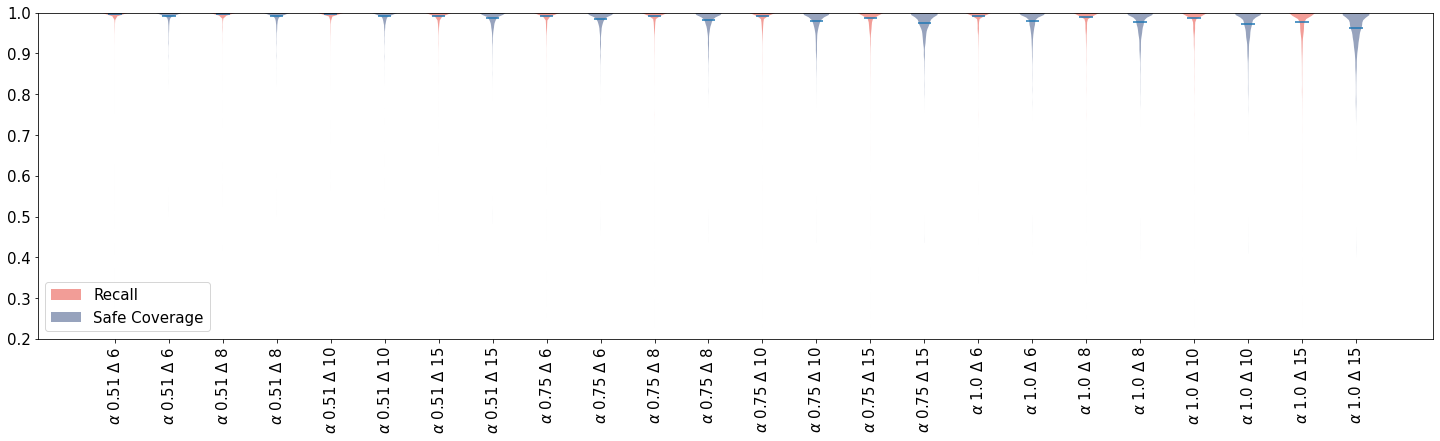

In [53]:
violinplot_stacked(groups, alphas, [6,8,10,15], ["recall", "safe_coverage"], id_range=[70,100])

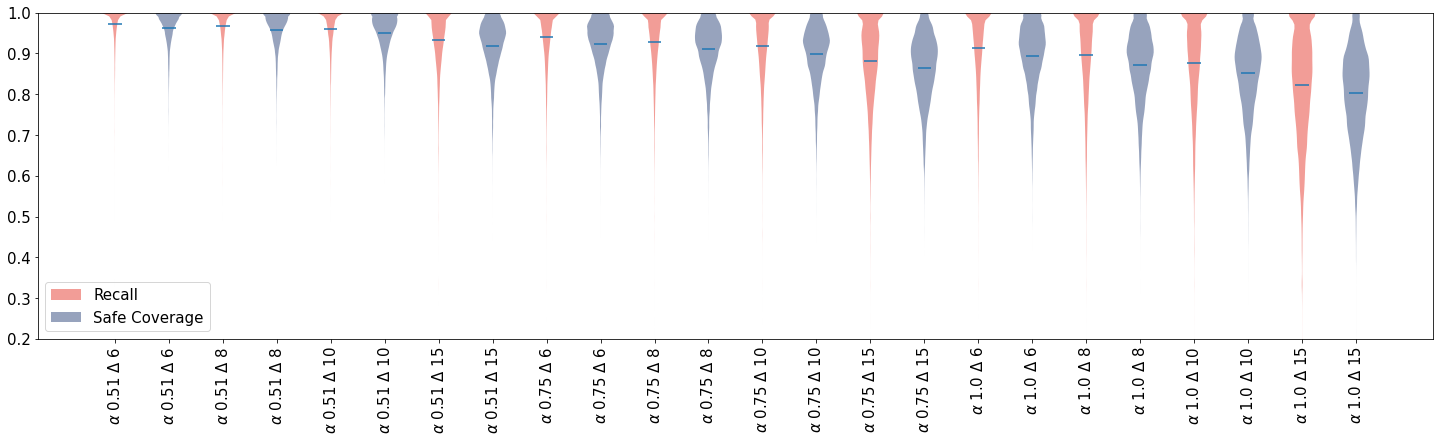

In [54]:
violinplot_stacked(groups, alphas, [6,8,10,15], ["recall", "safe_coverage"], id_range=[40,70])

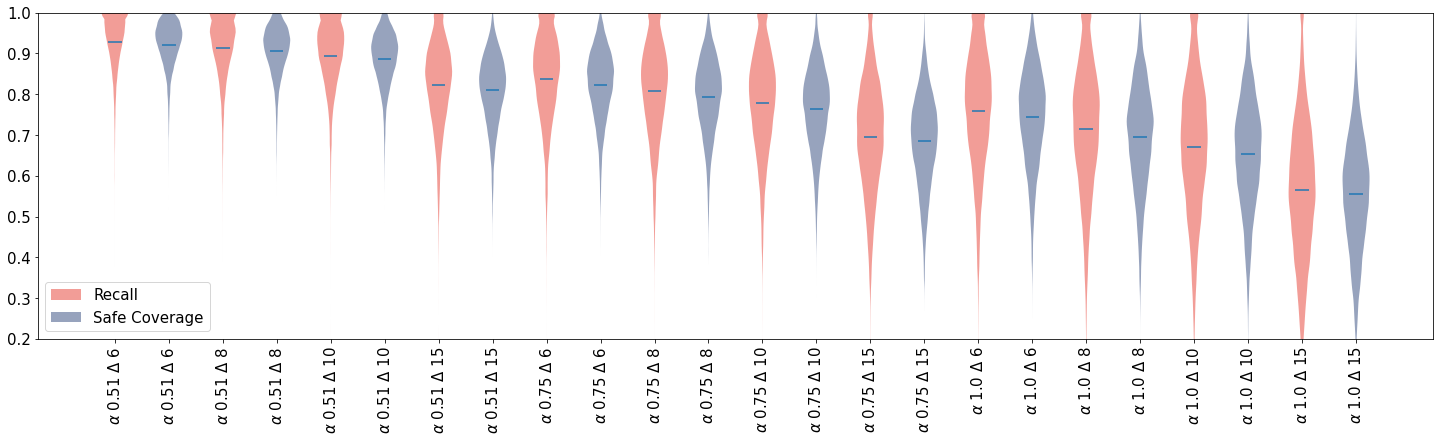

In [55]:
violinplot_stacked(groups, alphas, [6,8,10,15], ["recall", "safe_coverage"], id_range=[20,40])

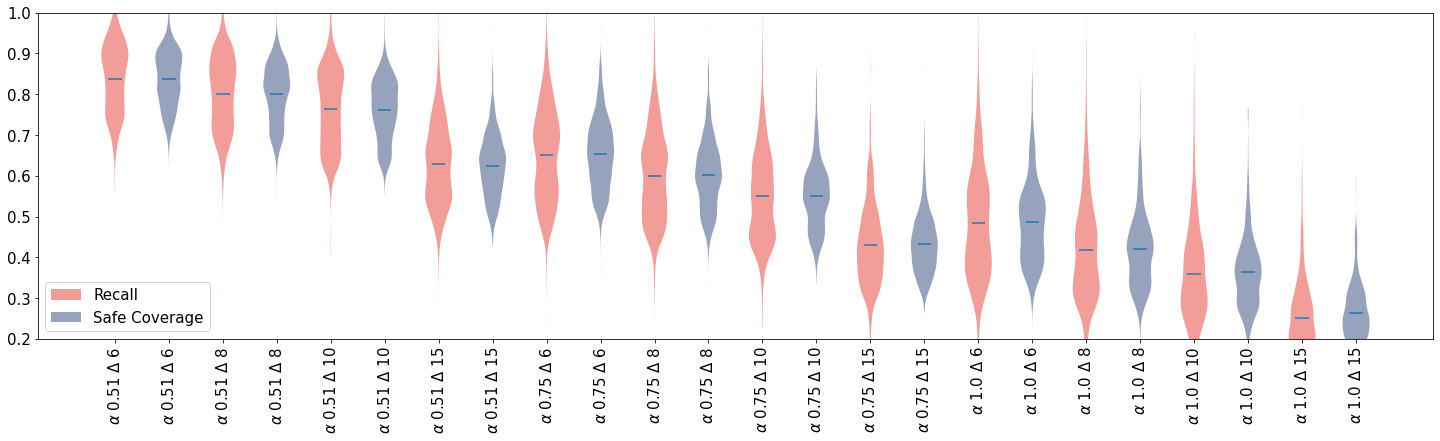

In [56]:
violinplot_stacked(groups, alphas, [6,8,10,15], ["recall", "safe_coverage"], id_range=[0,20])

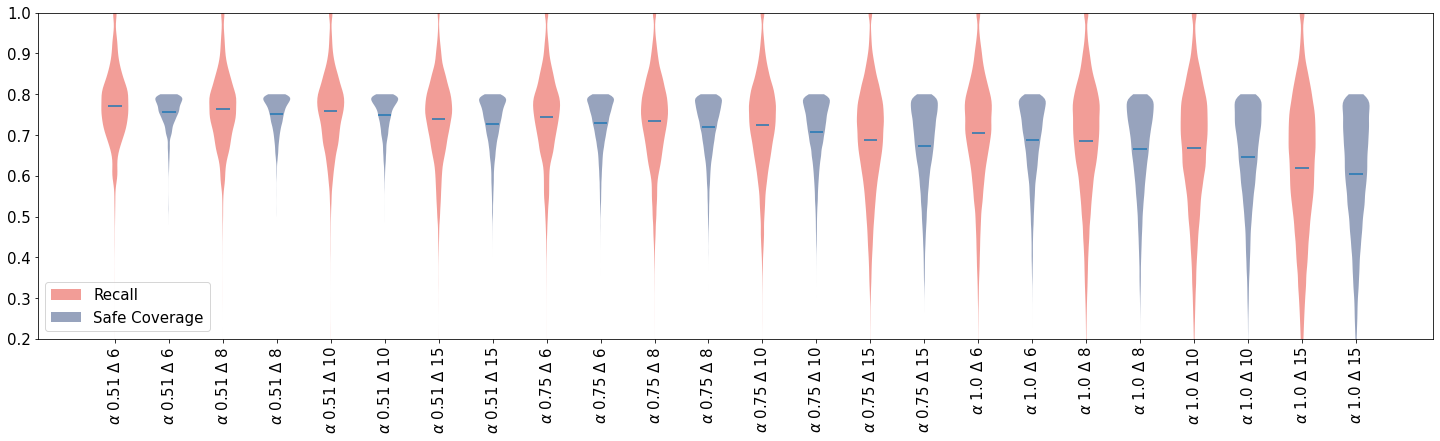

In [50]:
violinplot_stacked(groups, alphas, [6,8,10,15], ["recall", "safe_coverage"], sc_range=[0.0,0.8])

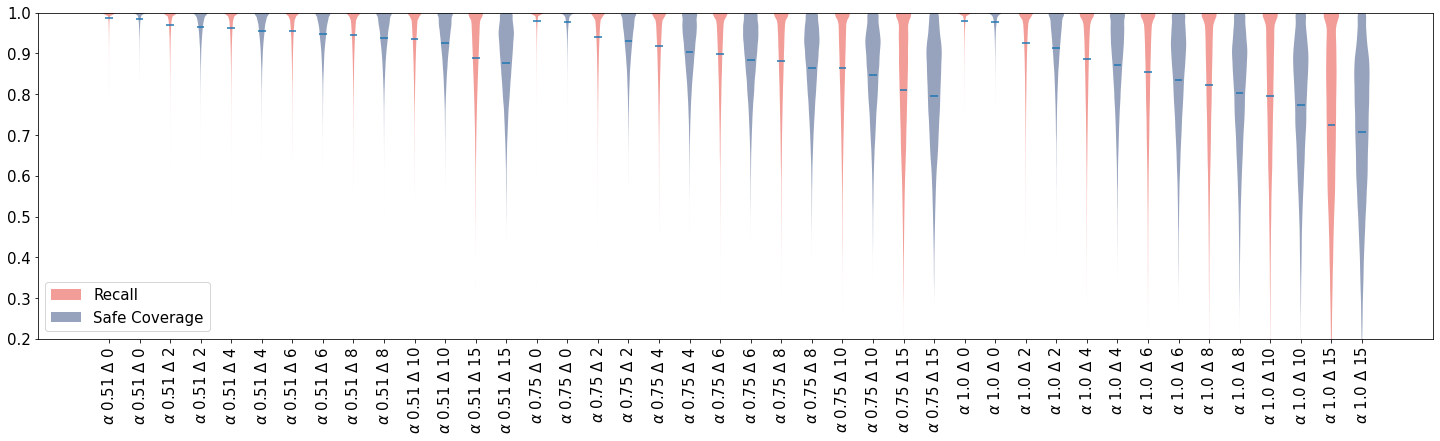

In [51]:
violinplot_stacked(groups, alphas, deltas, ["recall", "safe_coverage"])

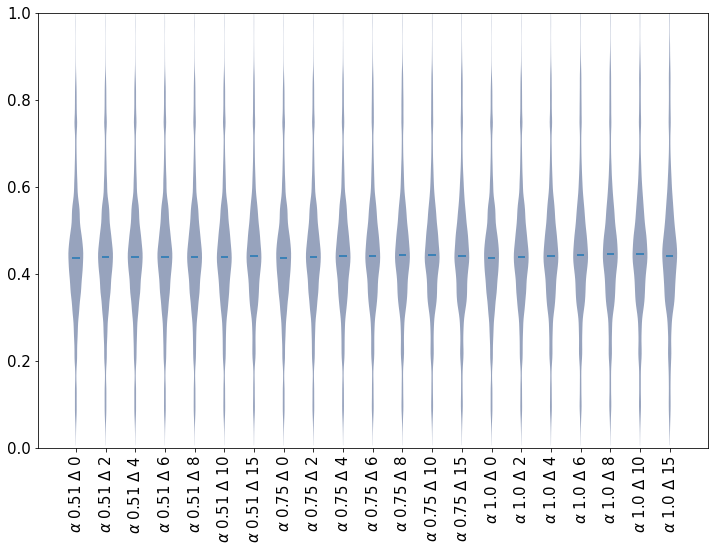

In [45]:
violinplot(groups, alphas, deltas, ["precision"])

Precision and recall heatmap for different alpha and delta parameters, all identities (%).

In [37]:
def grid_heatmap_id(groups, x, y, alpha, delta, id_range):
    fig, axes = plt.subplots(nrows=1, ncols=len(id_range), figsize=(7*len(id_range), 5))

    for i, (bot, top) in enumerate(id_range):
            df = groups[(alpha, delta)]

            df = df[(bot <= df.identity) & (df.identity <= top)]
            h = axes[i].hist2d(
                df[x].values, df[y].values,
                bins=(50,50), cmap=plt.cm.jet, range=np.array([(0,1),(0,1)]),
                density=True,
                norm=colors.Normalize()
            )
            fig.colorbar(h[3], ax=axes[i])

            axes[i].set_title(f"Identity Range: {bot}% - {top}%")
            axes[i].set_xlabel(x)
            if y == "safe_coverage":
                axes[i].set_ylabel("Safe Coverage")
            else:
                axes[i].set_ylabel(y)

    
    plt.savefig("heatmap_id_shift.pdf")

    plt.show()

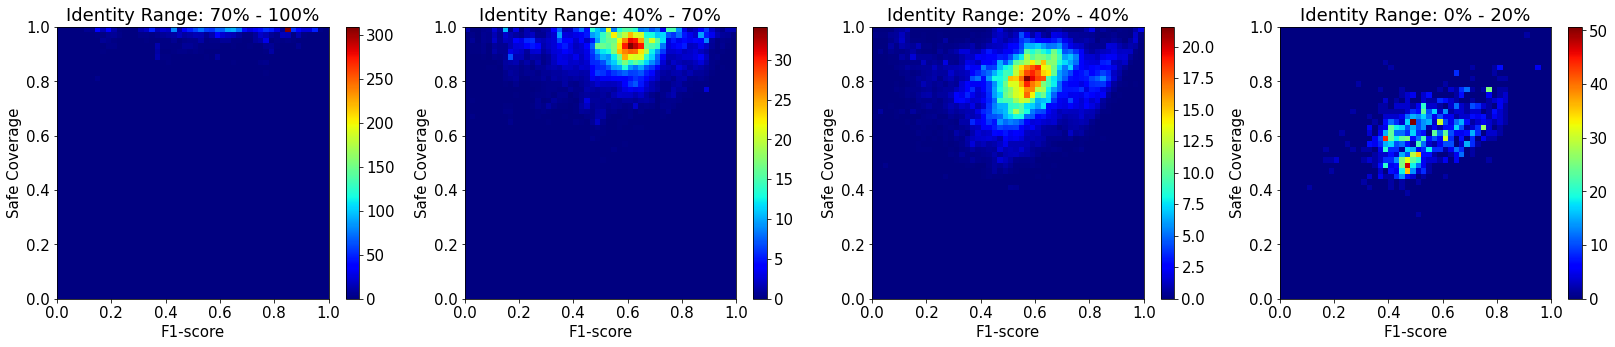

In [57]:
grid_heatmap_id(groups, "F1-score", "safe_coverage", 75, 8, id_range=list(reversed([(0,20), (20, 40), (40,70), (70,100)])))

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]
0
0
1
0
2
0
0
1
1
1
2
1
0
2
1
2
2
2
0
3
1
3
2
3
0
4
1
4
2
4
0
5
1
5
2
5
0
6
1
6
2
6


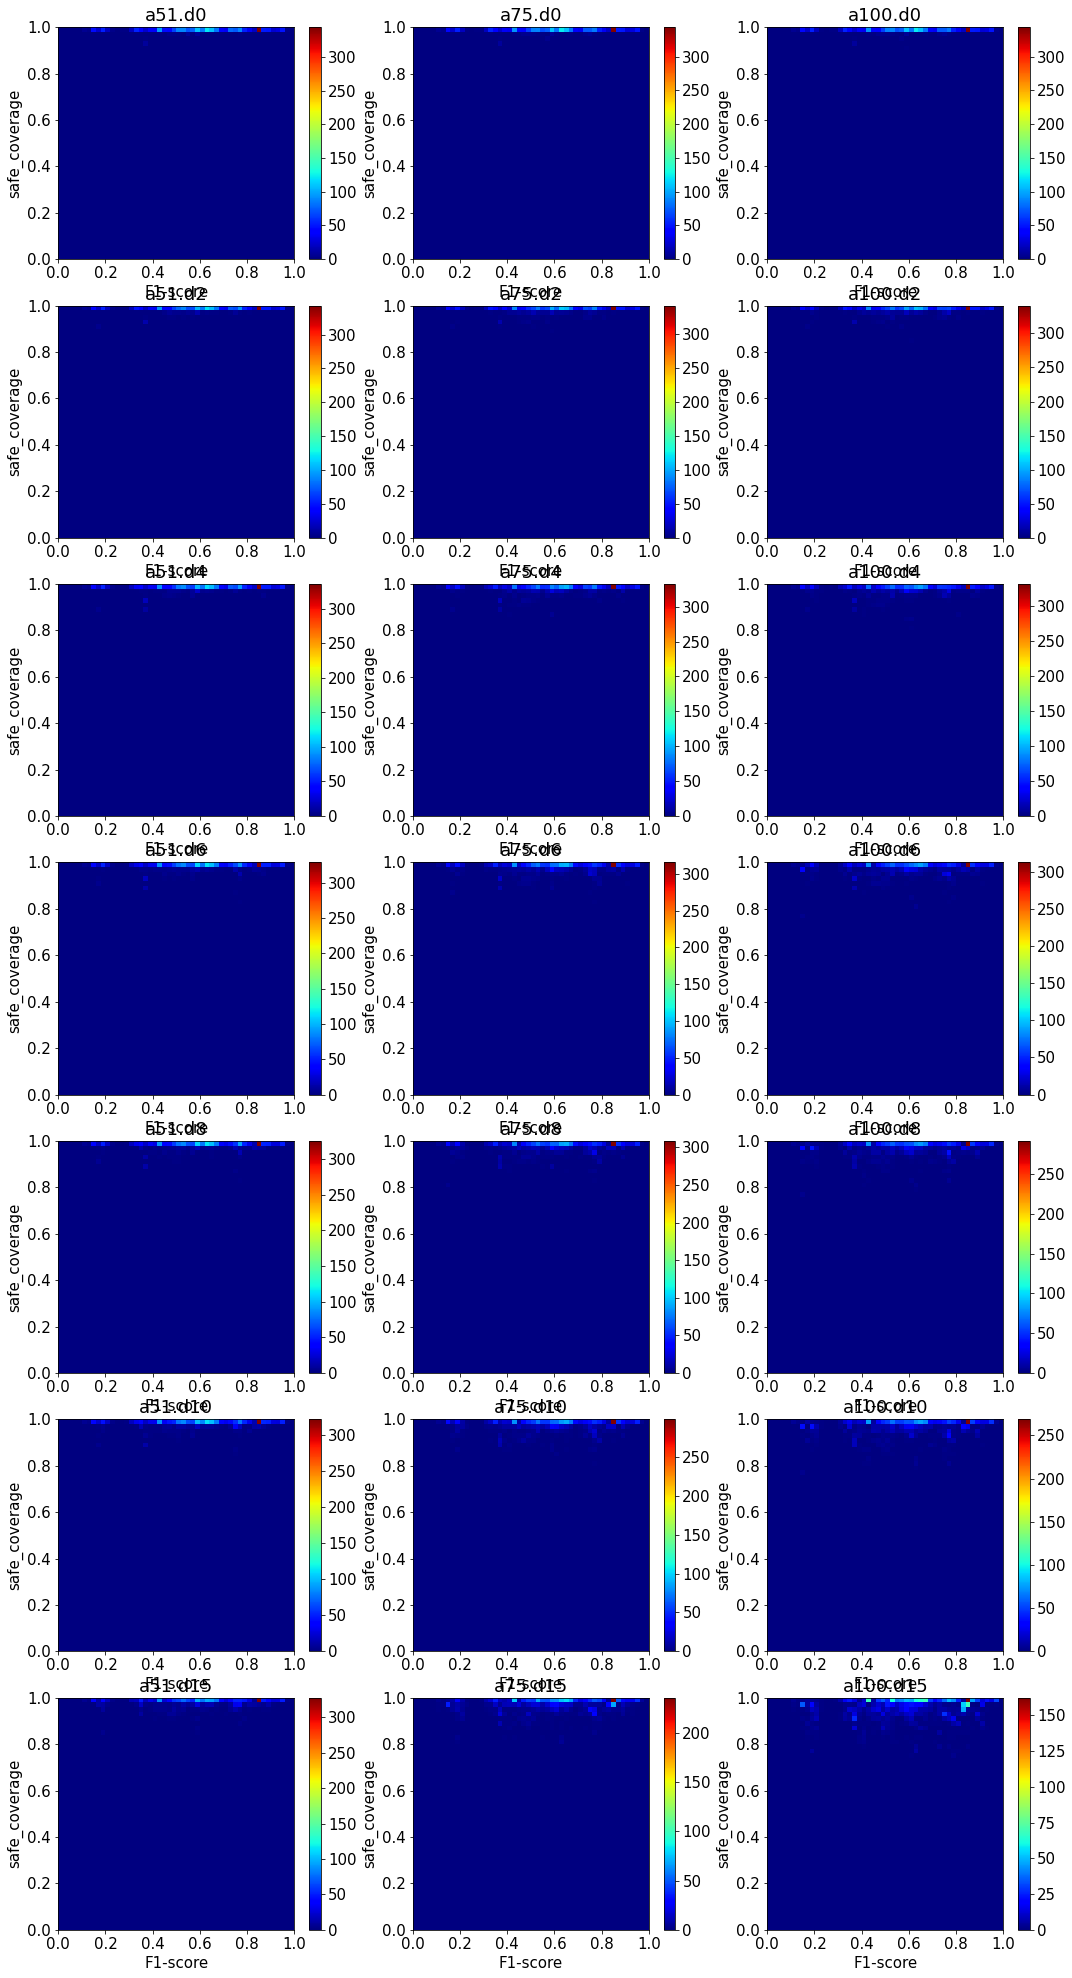

In [39]:
grid_heatmap(groups, "F1-score", "safe_coverage", alphas, deltas, id_range=[70, 100])


0
0
1
0
2
0
0
1
1
1
2
1
0
2
1
2
2
2
0
3
1
3
2
3
0
4
1
4
2
4
0
5
1
5
2
5
0
6
1
6
2
6


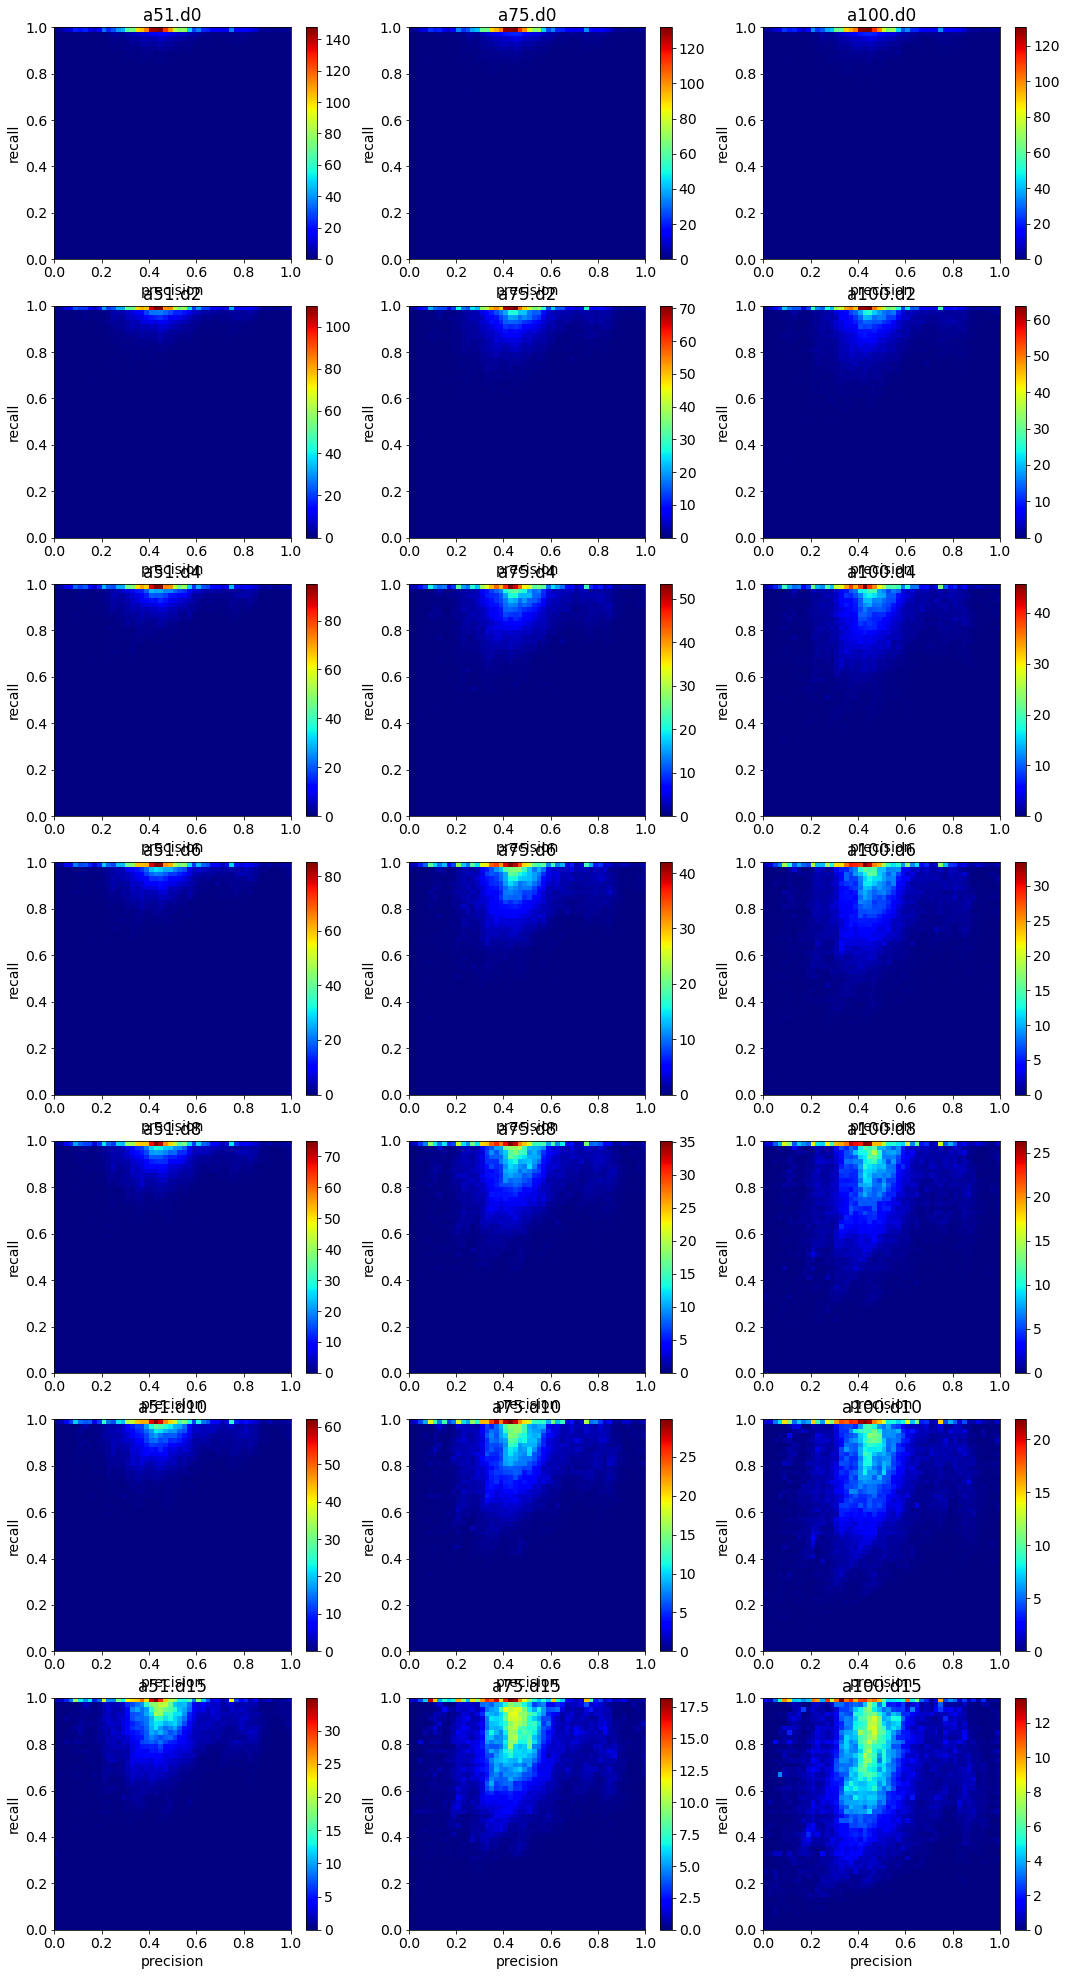

In [88]:
grid_heatmap(groups, "precision", "recall", alphas, deltas)

F1-score vs. Safety Coverage (compression), all identities.

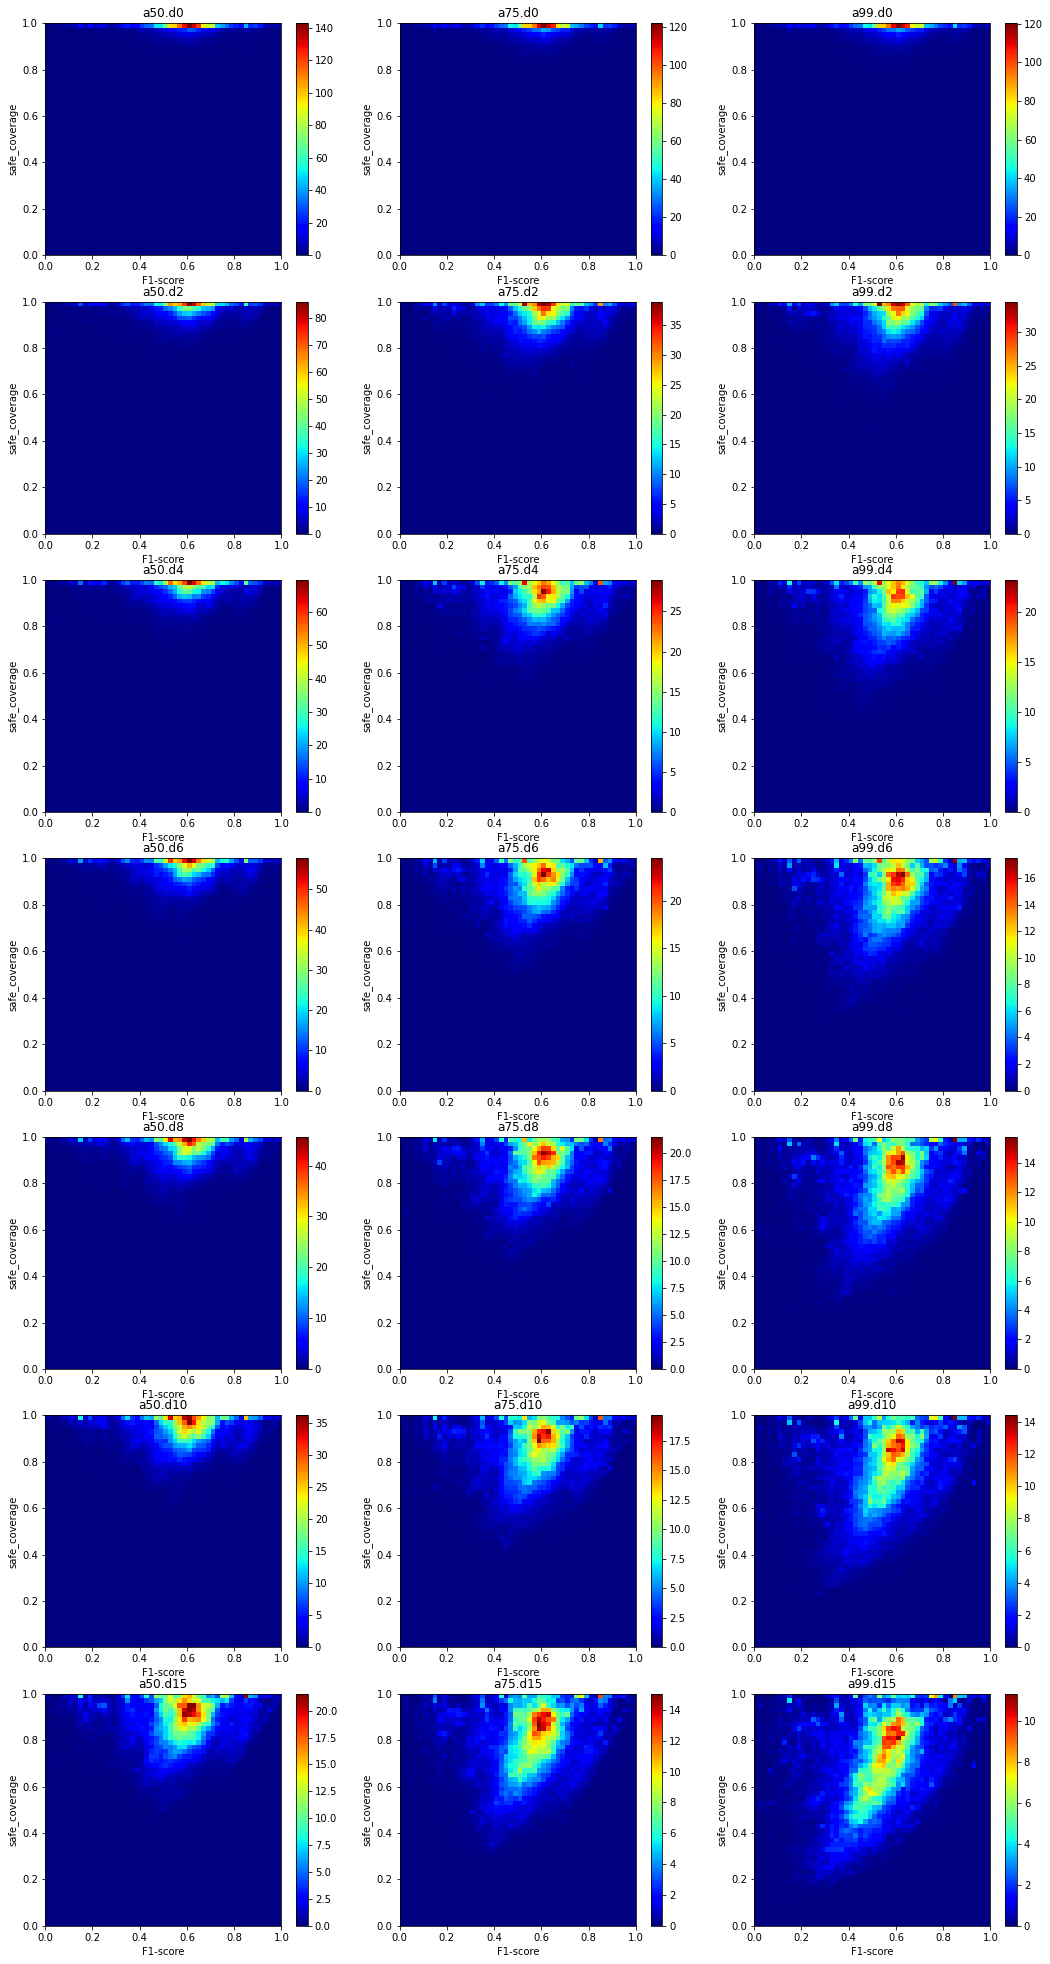

In [ ]:
grid_heatmap(groups, "F1-score", "safe_coverage", alphas, deltas)

Boxplots, all identities.

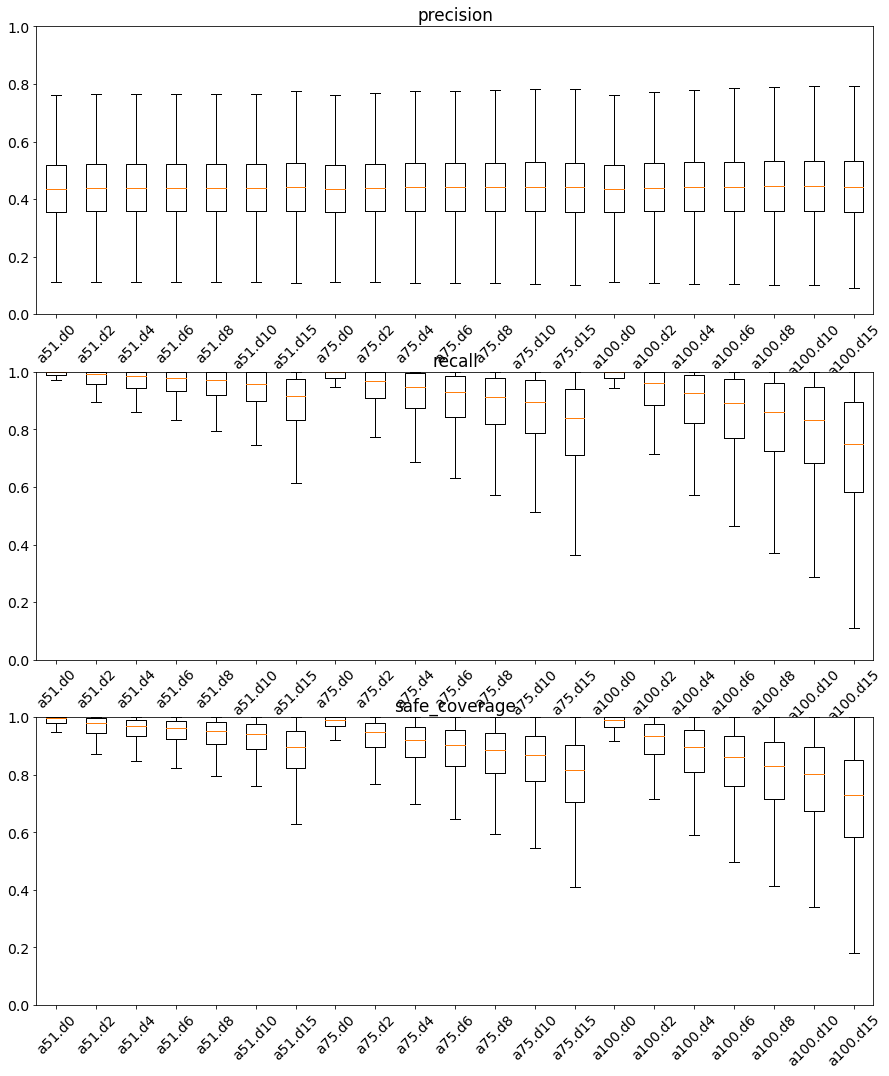

In [89]:
boxplot(groups, alphas, deltas, ["precision", "recall", "safe_coverage"])

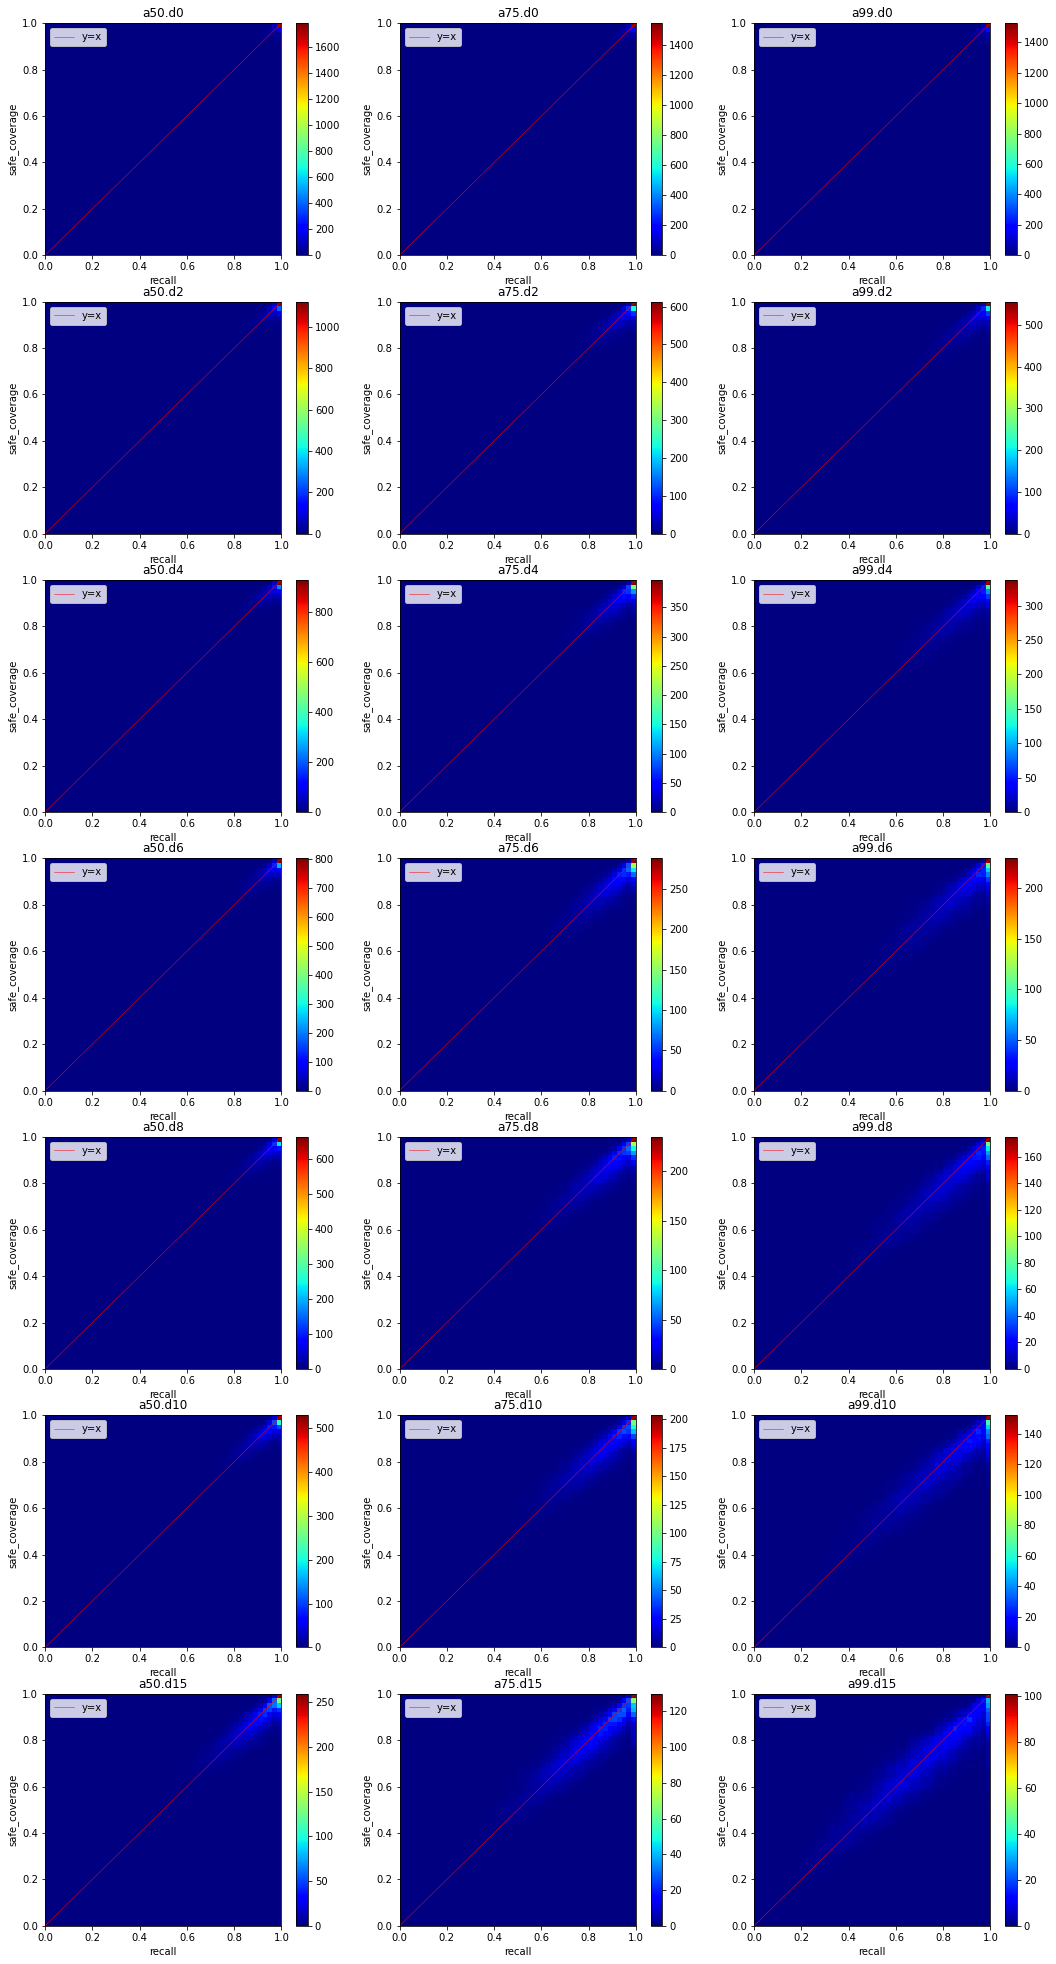

In [ ]:
grid_heatmap(groups, "recall", "safe_coverage", alphas, deltas, plot_xy_line=True)

In [80]:
def plot_kde(groups, x, y, alpha, deltas, id_range=None):
    for i, d in enumerate(deltas):
        if id_range != None:
            df = groups[(alpha, d)][(id_range[0] <= groups[(alpha,d)].identity) & (groups[(alpha,d)].identity <= id_range[1])]
        else:
            df = groups[(alpha, d)]

        ax = sb.jointplot(
            data=df, x=x, y=y, fill=True,
            xlim=(0,1), ylim=(0,1), color="#4CB391", kind="kde",
        )
        ax.fig.suptitle(f"a{alpha}.d{d}")
    
    # plt.savefig(f"kde_a.{alpha}_d.{delta}_{x}_{y}.pdf", bbox_inches="tight")
    plt.show()

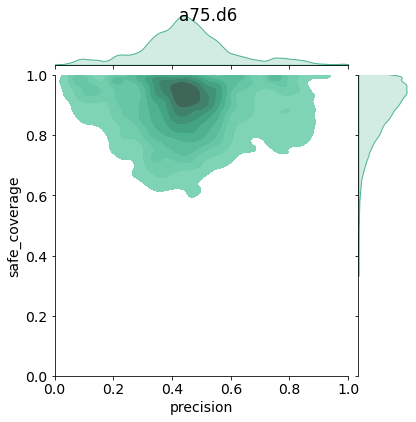

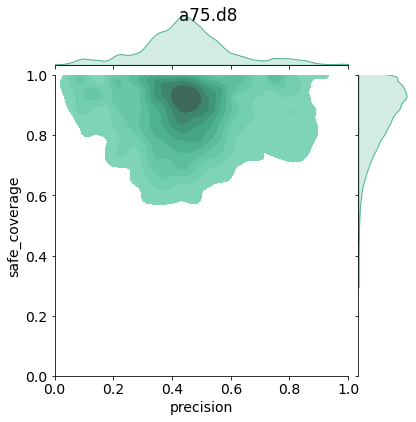

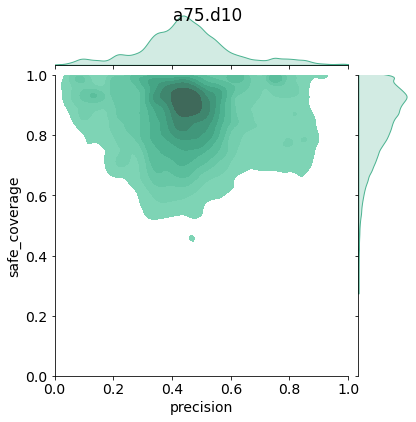

In [81]:
plot_kde(groups, "precision", "safe_coverage", 75, [6,8,10])

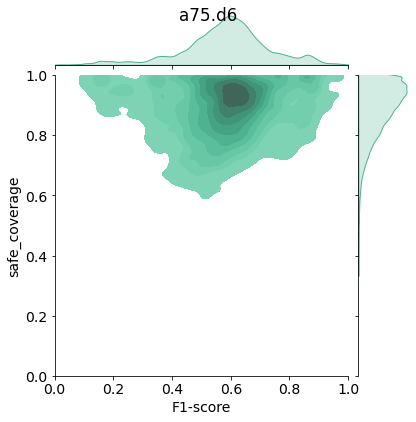

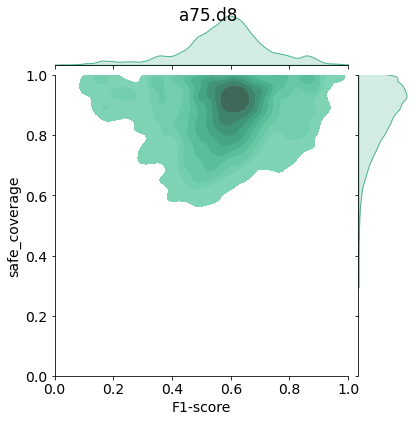

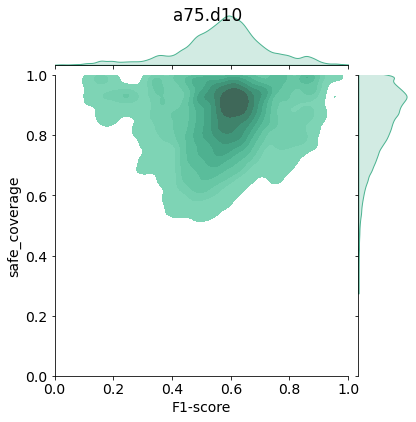

In [82]:
plot_kde(groups, "F1-score", "safe_coverage", 75, [6,8,10])

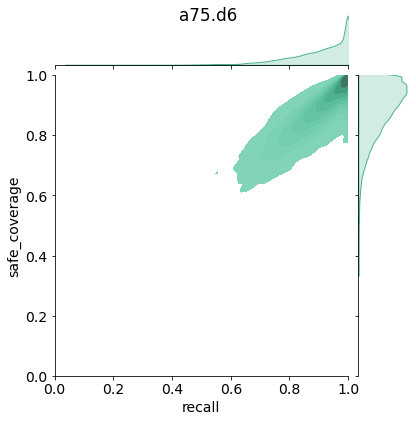

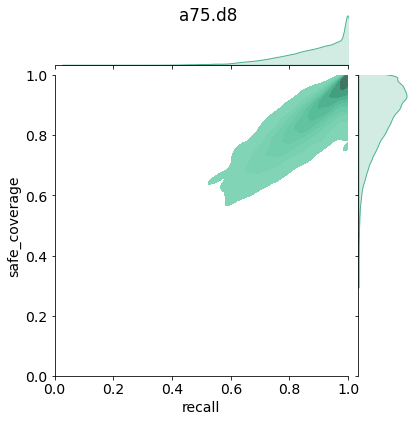

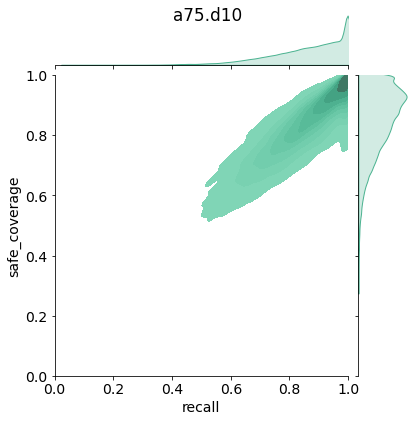

In [84]:
plot_kde(groups, "recall", "safe_coverage", 75, [6,8,10])

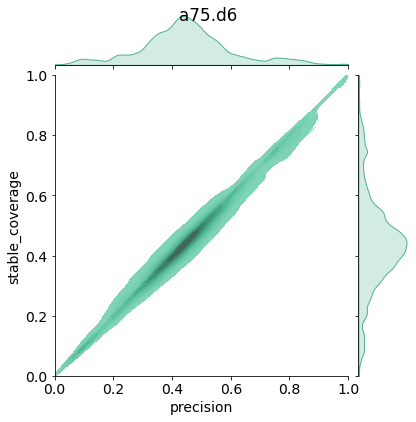

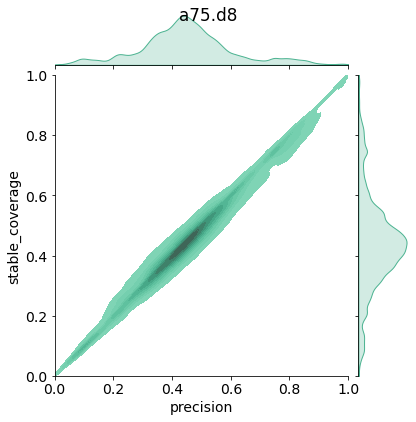

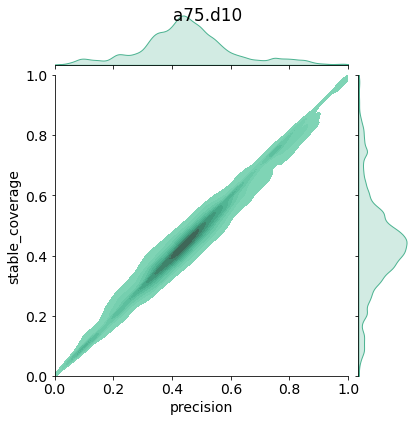

In [85]:
plot_kde(groups, "precision", "stable_coverage", 75, [6,8,10])

In [86]:
def grid_safe_coverage_binned(groups, y, alphas, deltas, bins=21, plot_xy_line=True):
    fig, axes = plt.subplots(nrows=len(deltas), ncols=len(alphas), figsize=(6*len(alphas), 5*len(deltas)))
    for j, d in enumerate(deltas):
        for i, a in enumerate(alphas):
            Y = np.zeros(bins)
            X = np.linspace(0, 1, num=bins)
            for k, x in enumerate(X):
                Y[k] = groups[(a,d)][groups[(a, d)]["safe_coverage"] < x][y].mean()
            axes[j][i].plot(X, Y)
            if plot_xy_line:
                axes[j][i].plot([0,1], [0,1], color="r", linewidth=0.5, label="y=x")
                axes[j][i].legend()
            axes[j][i].set_title(f"a{a}.d{d}")
            axes[j][i].set_xlabel("Safe Coverage")
            axes[j][i].set_ylabel(y)
    plt.show()

In [74]:
def compressibility(groups, alphas, deltas, bins=21, id_range=None, sc_range=None):
    fig, axes = plt.subplots(nrows=1, ncols=len(deltas), figsize=(6*len(deltas), 5))
    L = np.linspace(0, 1, bins)
    for (j,d) in enumerate(deltas):
        for (i,a) in enumerate(alphas):
            df = groups[(a, d)]
            if id_range != None:
                df = df[(id_range[0] <= df.identity) & (df.identity <= id_range[1])]
            if sc_range != None:
                df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]
            loss = df.FN / (df.TP + df.FN)
            ALL = sum(df.TP + df.FP + df.TN + df.FN)
            Y = np.zeros(bins, dtype=float)
            for (k,x) in enumerate(L):
                df_C = df[loss <= x]    # sequences that can be compressed
                df_U = df[loss > x]     # sequences that cannot be compressed
                # Y[k] = ALL / (sum(df_C.TP + df_C.FP) + sum(df_U.TP+df_U.FP+df_U.TN+df_U.FN)) - 1.0
                Y[k] = (sum(df_C.TN + df_C.FN)) / ALL
            axes[j].plot(L, Y, label=r"$\alpha$ " + str(a / 100.0), color=PALLETTE[i])
        # axes[j].plot([0,1], [0,1], color="r", linewidth=0.5, label="y=x")
        axes[j].set_title(r" $\Delta$ " + str(d))
        axes[j].set_xlabel("Loss of stable <= x")
        axes[j].set_ylabel("% compressed")
        axes[j].legend()
        axes[j].set_ylim(0,1)
    
    plt.savefig(f"compression_sc_{sc_range[0]}-{sc_range[1]}.pdf", bbox_inches="tight")
    plt.show()

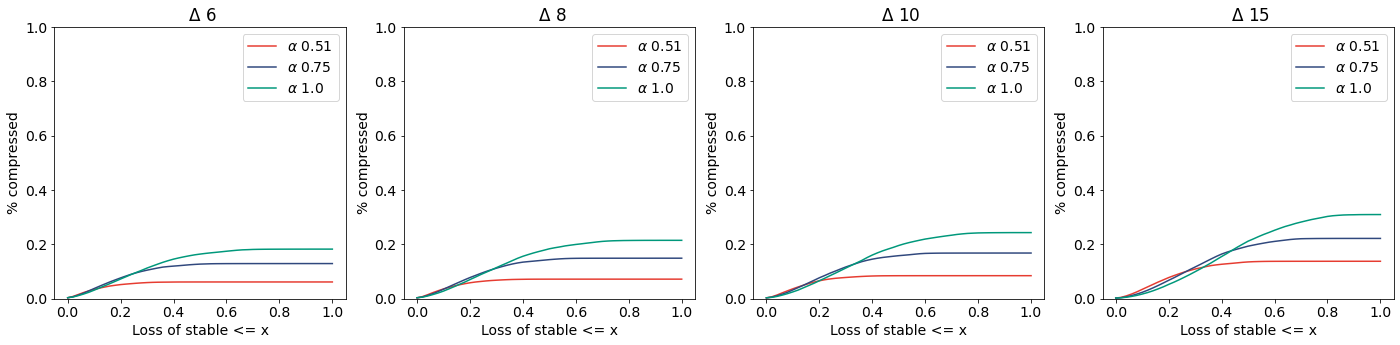

In [73]:
compressibility(groups, alphas, [6,8,10,15], 51, id_range=[0,100])


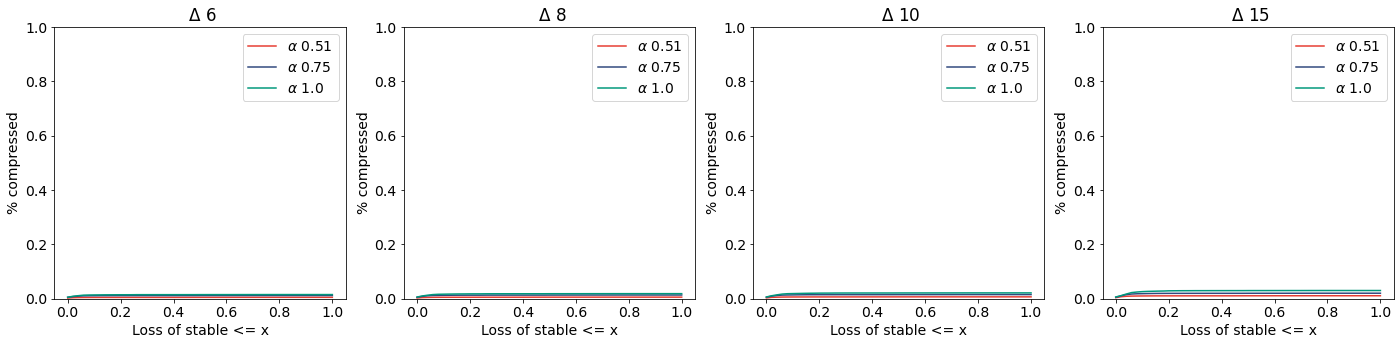

In [69]:
compressibility(groups, alphas, [6,8,10,15], 51, id_range=[70,100])

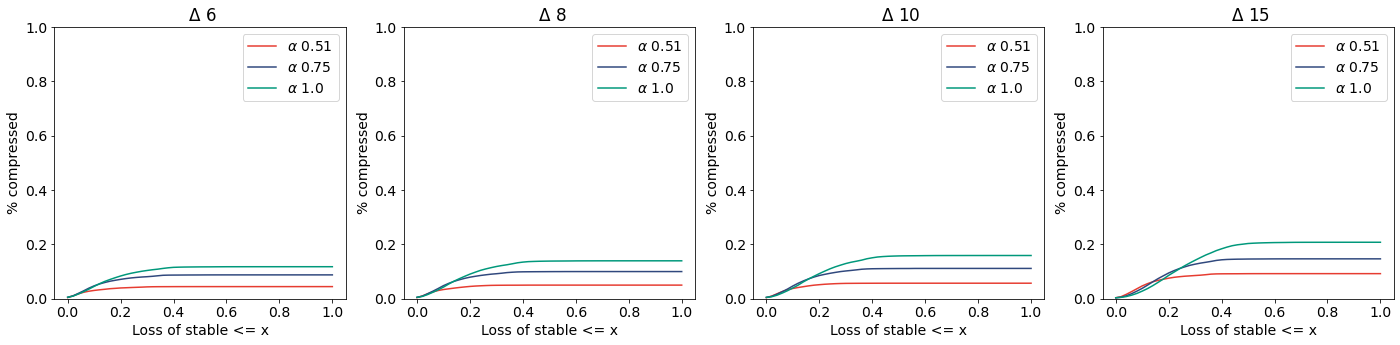

In [70]:
compressibility(groups, alphas, [6,8,10,15], 51, id_range=[40, 70])

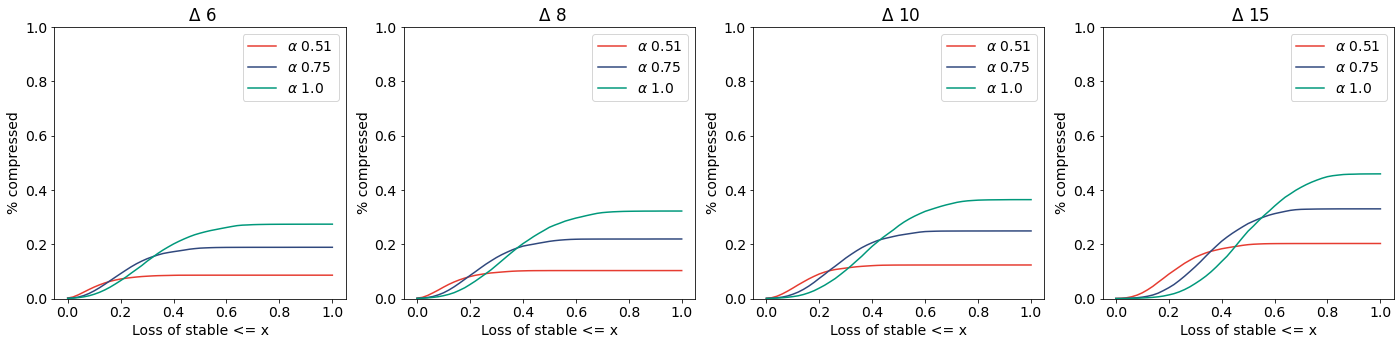

In [71]:
compressibility(groups, alphas, [6,8,10,15], 51, id_range=[20, 40])

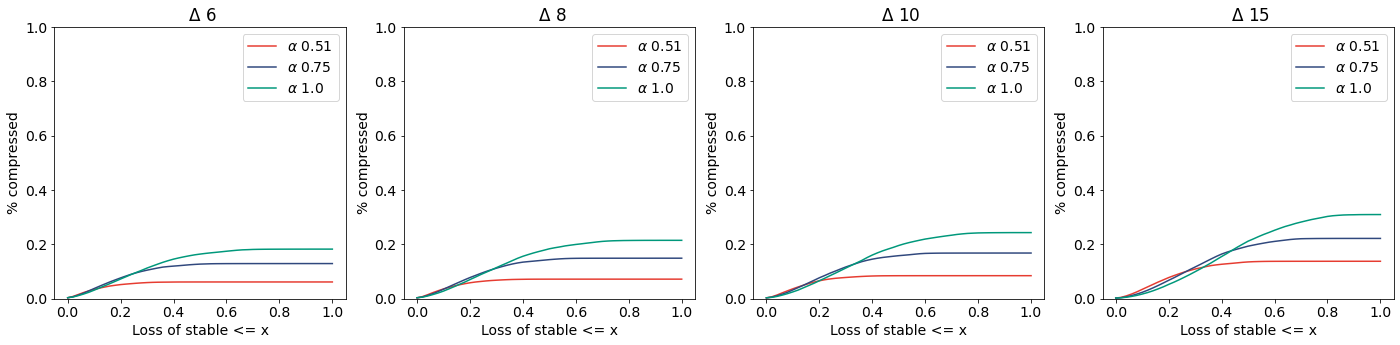

In [75]:
compressibility(groups, alphas, [6,8,10,15], 51, sc_range=[0.0,1.0])

In [66]:
plt.rcParams.update({'font.size': 14})

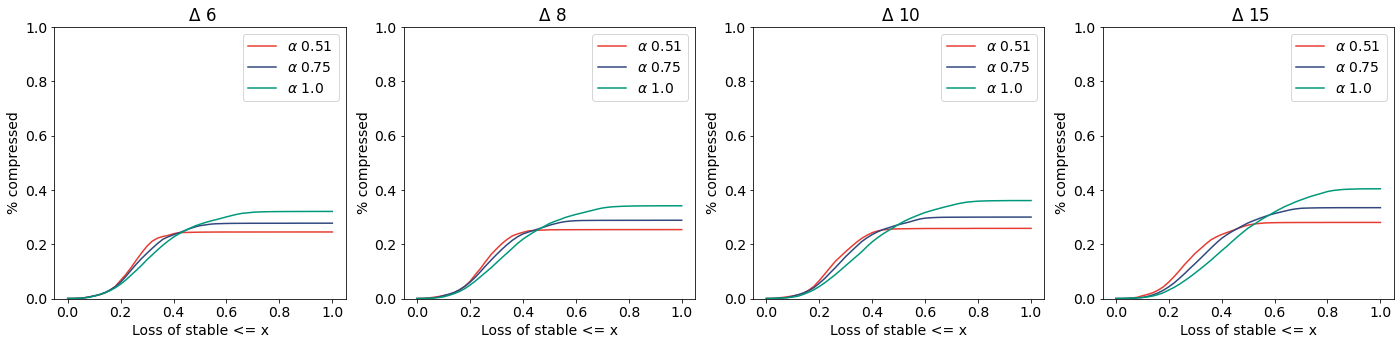

In [76]:
compressibility(groups, alphas, [6,8,10,15], 51, sc_range=[0.0,0.8])

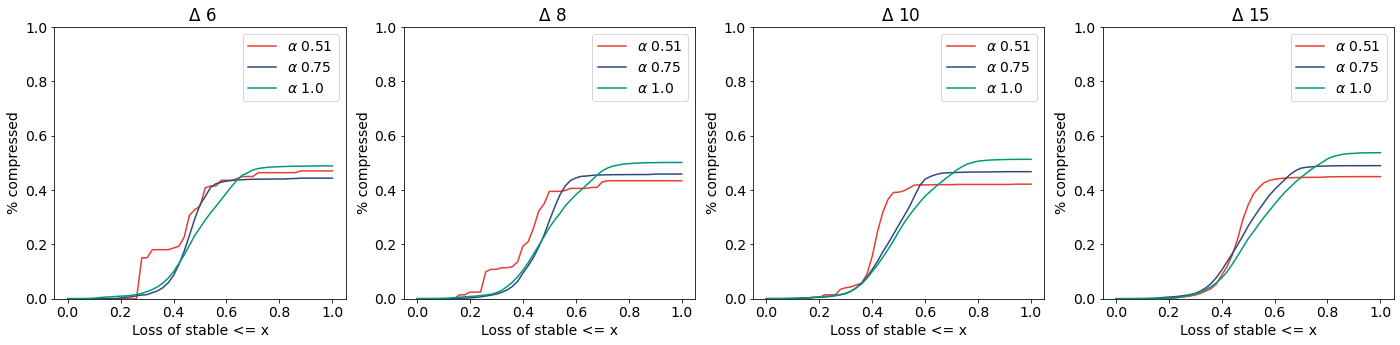

In [77]:
compressibility(groups, alphas, [6,8,10,15], 51, sc_range=[0.0,0.6])

In [ ]:
def compressed_percentage(groups, alphas, deltas, bins=21, id_range=None, sc_range=None):
    fig, axes = plt.subplots(nrows=len(deltas), ncols=len(alphas), figsize=(6*len(alphas), 5*len(deltas)))
    L = np.linspace(0, 1, bins)
    for (i,a) in enumerate(alphas):
        for (j,d) in enumerate(deltas):
            df = groups[(a, d)]
            if id_range != None:
                df = df[(id_range[0] <= df.identity) & (df.identity <= id_range[1])]
            if sc_range != None:
                df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]
            loss = df.FN / (df.TP + df.FN)
            ALL = sum(df.TP + df.FP + df.TN + df.FN)
            Y = np.zeros(bins, dtype=float)
            for (k,x) in enumerate(L):
                df_C = df[loss <= x]    # sequences that can be compressed
                df_U = df[loss > x]     # sequences that cannot be compressed
                Y[k] = (sum(df_C.TP + df_C.FP) + sum(df_U.TP+df_U.FP+df_U.TN+df_U.FN)) / ALL
            
            axes[j][i].plot(L, Y)
            tmax = sum(df.TP + df.FN) / ALL
            axes[j][i].plot([0,1], [tmax,tmax], color="r", linewidth=0.5, label="Stable coverage")
            axes[j][i].legend()
            axes[j][i].set_title(f"a{a}.d{d}")
            axes[j][i].set_xlabel("Loss of stable <= x")
            axes[j][i].set_ylabel("% of whole database")
            axes[j][i].set_ylim(0,1)
    plt.show()

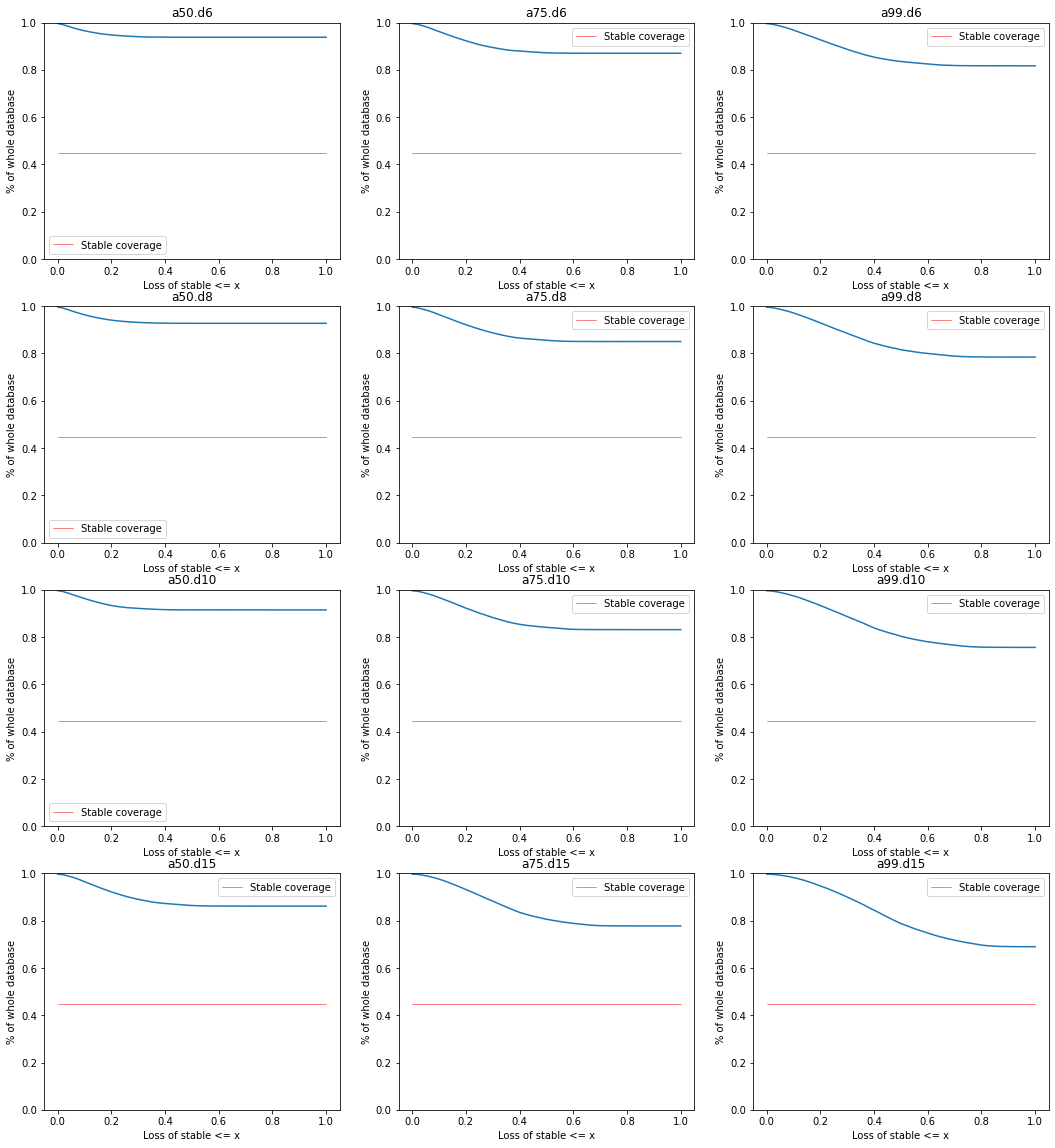

In [ ]:
compressed_percentage(groups, alphas, [6,8,10,15], 51, sc_range=[0.0,1.0])

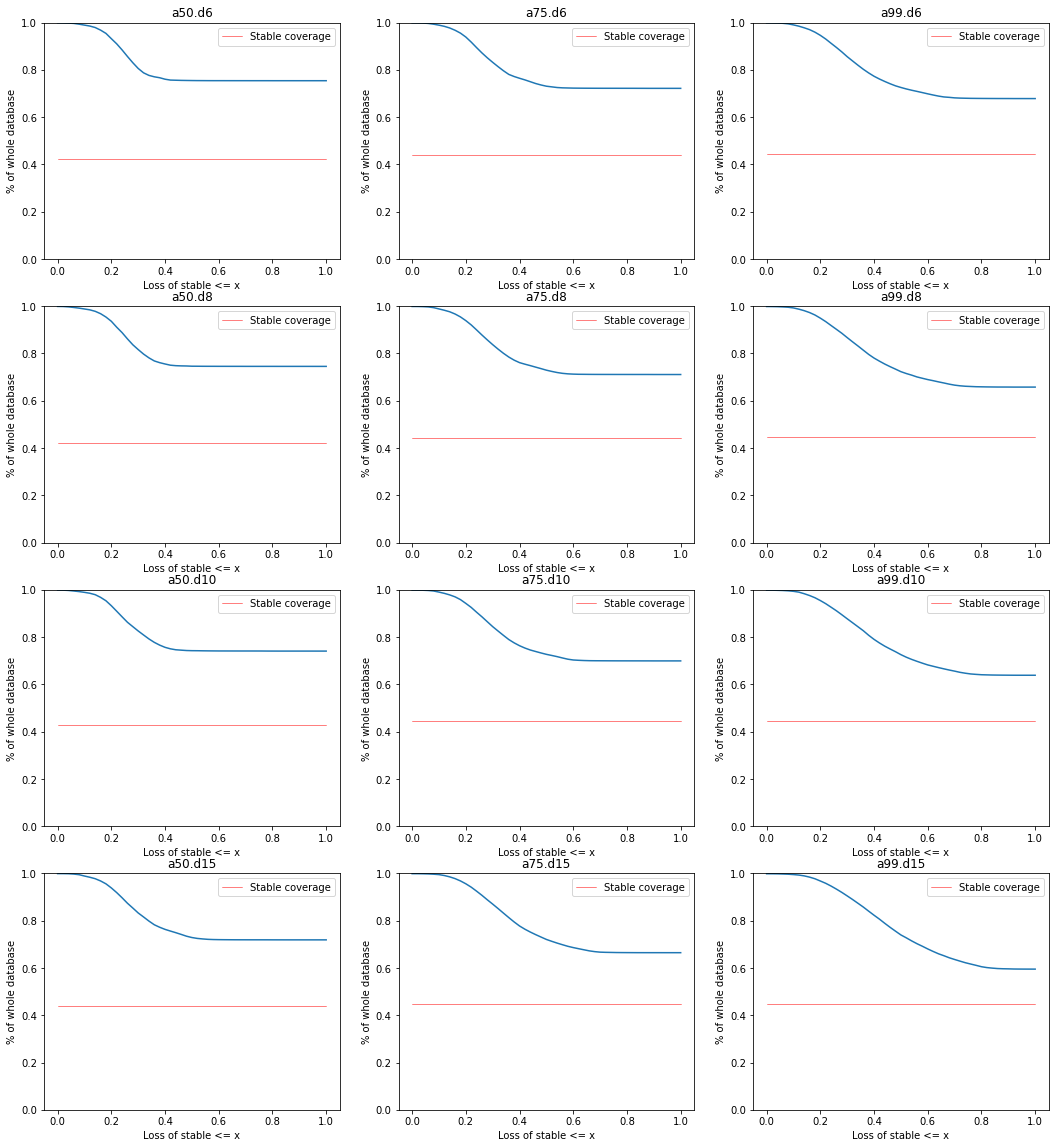

In [ ]:
compressed_percentage(groups, alphas, [6,8,10,15], 51, sc_range=[0.0,0.8])

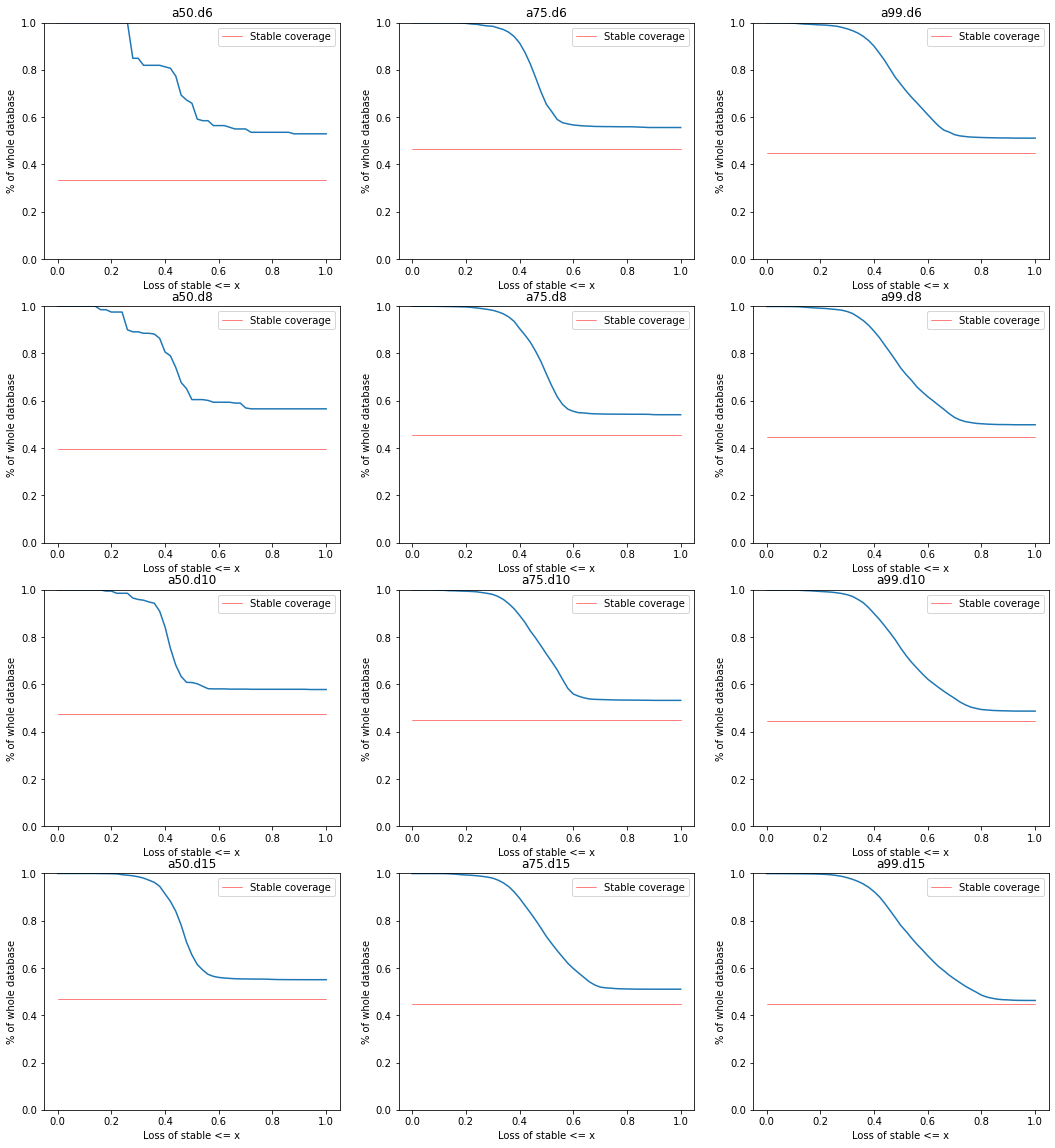

In [ ]:
compressed_percentage(groups, alphas, [6,8,10,15], 51, sc_range=[0.0,0.6])

In [68]:
def compressed_count(groups, alphas, deltas, bins=21, sc_range=None):
    fig, axes = plt.subplots(nrows=1, ncols=len(deltas), figsize=(5*len(deltas), 5))
    L = np.linspace(0, 1, bins)
    for (j,d) in enumerate(deltas):
        for (i,a) in enumerate(alphas):
            df = groups[(a, d)]
            if sc_range != None:
                df = df[(sc_range[0] <= df.safe_coverage) & (df.safe_coverage <= sc_range[1])]
            loss = df.FN / (df.TP + df.FN)
            Y = np.zeros(bins, dtype=float)
            for (k,x) in enumerate(L):
                df_C = df[loss <= x]    # sequences that can be compressed
                # df_U = df[loss > x]     # sequences that cannot be compressed
                Y[k] = len(df_C) / len(df)
            
            axes[j].plot(L, Y, label=r"$\alpha$ " + str(a/100.0))
            axes[j].legend(loc="lower right")
            axes[j].set_title(r" $\Delta$ " + str(d))
            axes[j].set_xlabel("Loss of stable <= x")
            axes[j].set_ylabel("Portion of sequences")
            axes[j].set_ylim(0,1)

    plt.savefig(f"counts_{sc_range[0]}-{sc_range[1]}.pdf")
    plt.show()

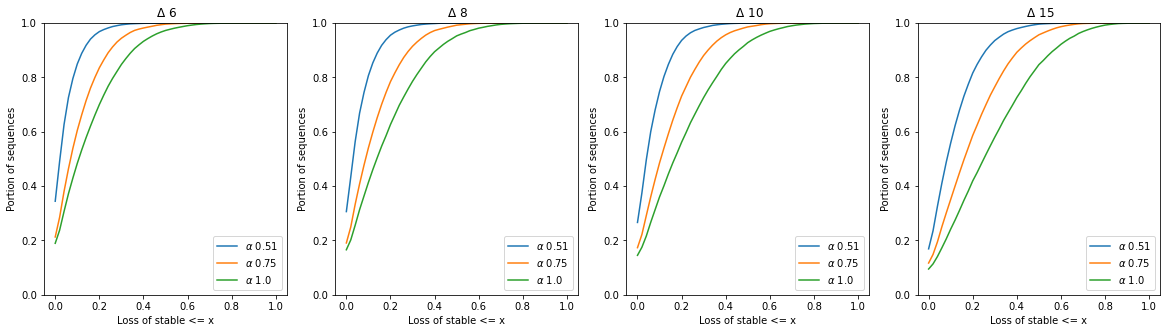

In [69]:
compressed_count(groups, alphas, [6,8,10,15], 51, sc_range=[0.0, 1.0])

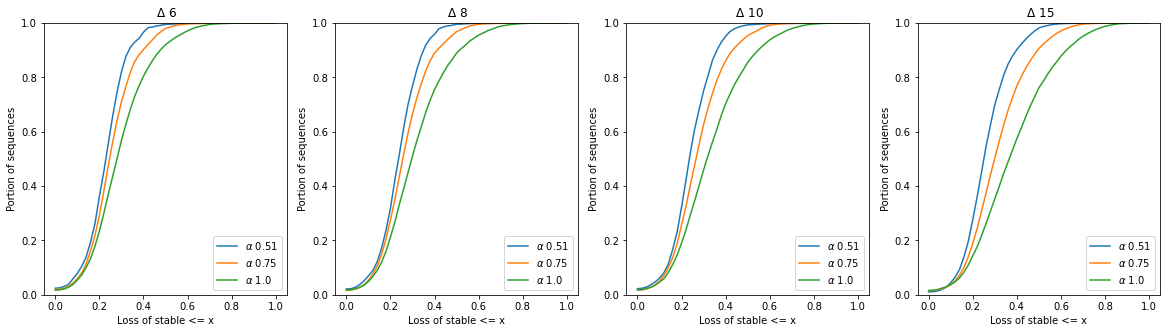

In [70]:
compressed_count(groups, alphas, [6,8,10,15], 51, sc_range=[0.0, 0.8])

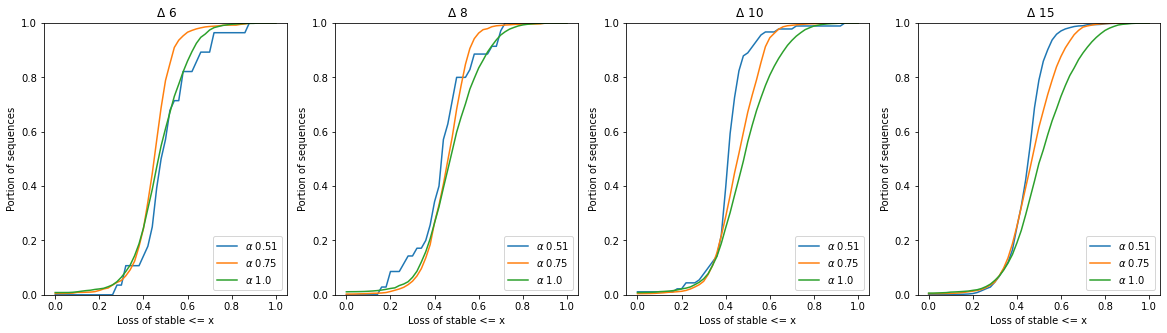

In [71]:
compressed_count(groups, alphas, [6,8,10,15], 51, sc_range=[0.0, 0.6])

/Users/lutrarutra/mambaforge/envs/jupyter/lib/python3.8/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


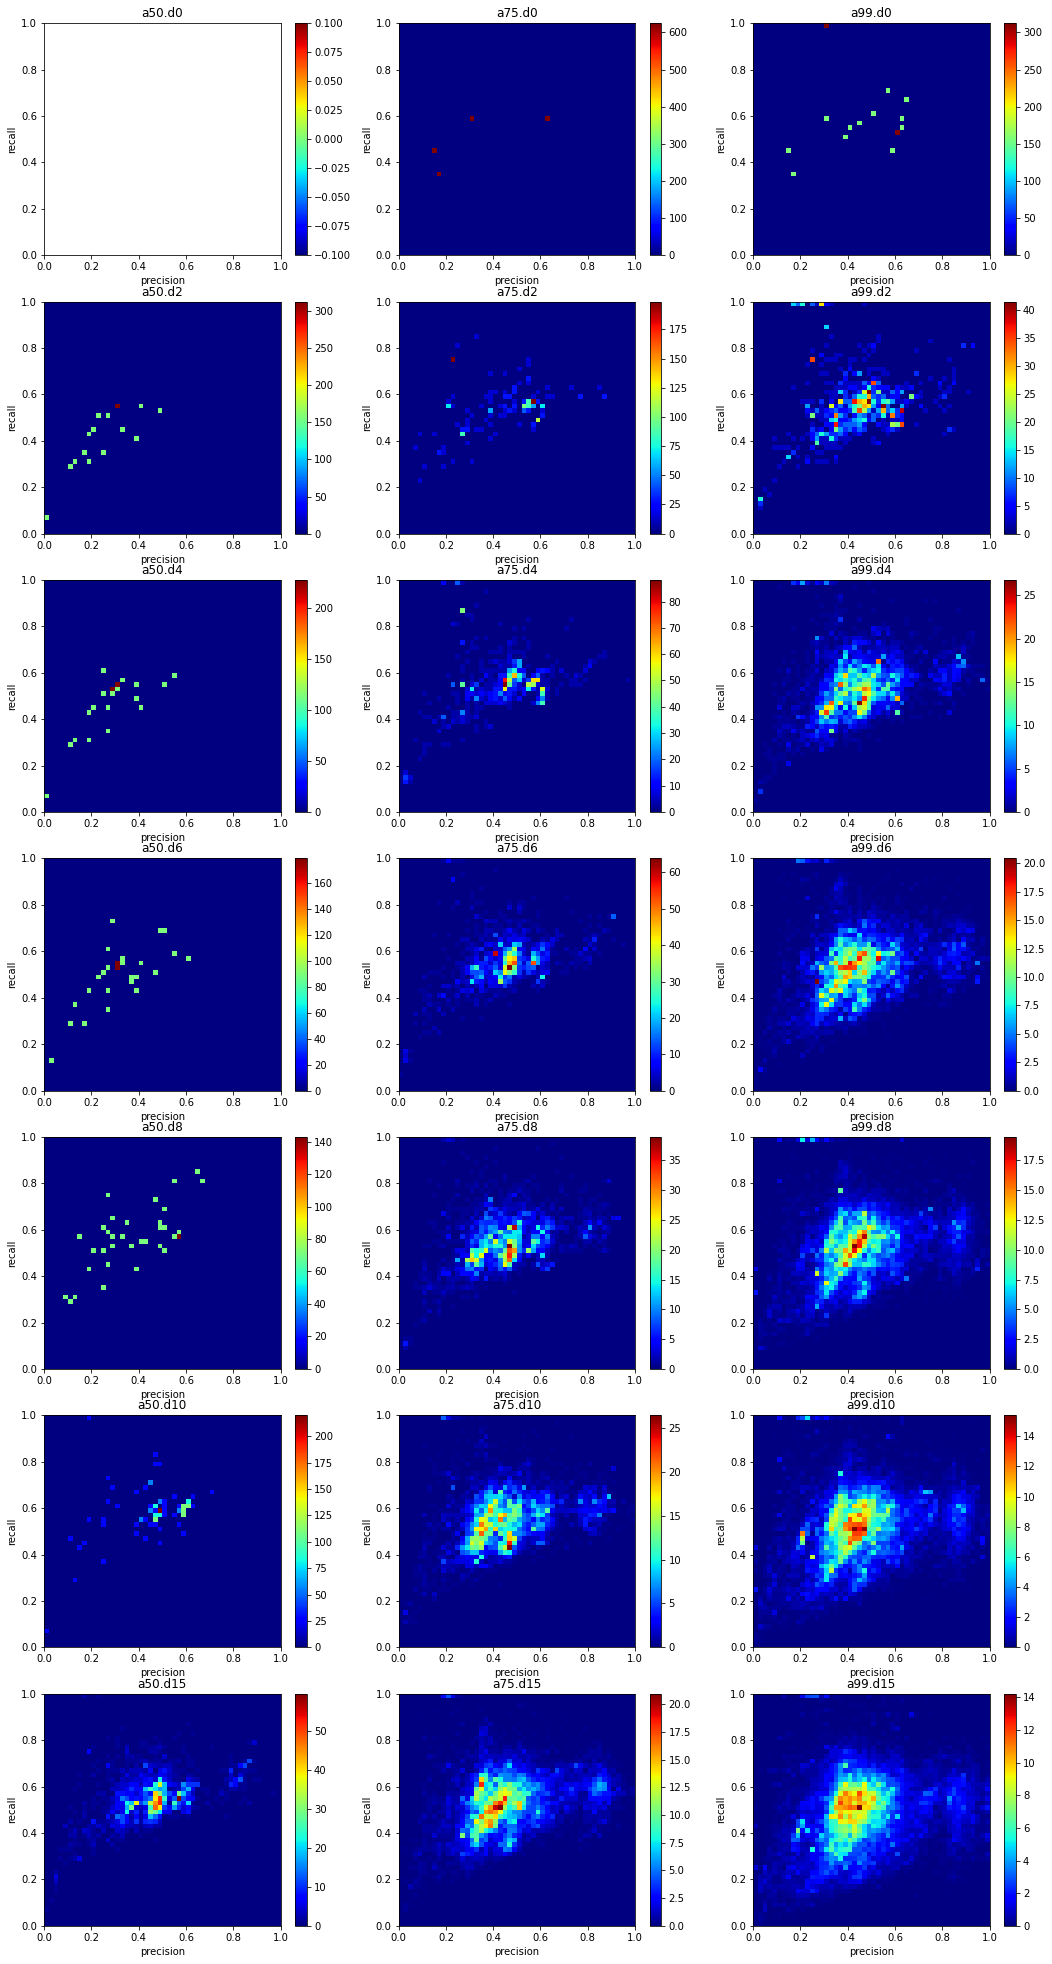

In [ ]:
grid_heatmap(groups, "precision", "recall", alphas, deltas, sc_range=[0.0,0.6])

/Users/lutrarutra/mambaforge/envs/jupyter/lib/python3.8/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


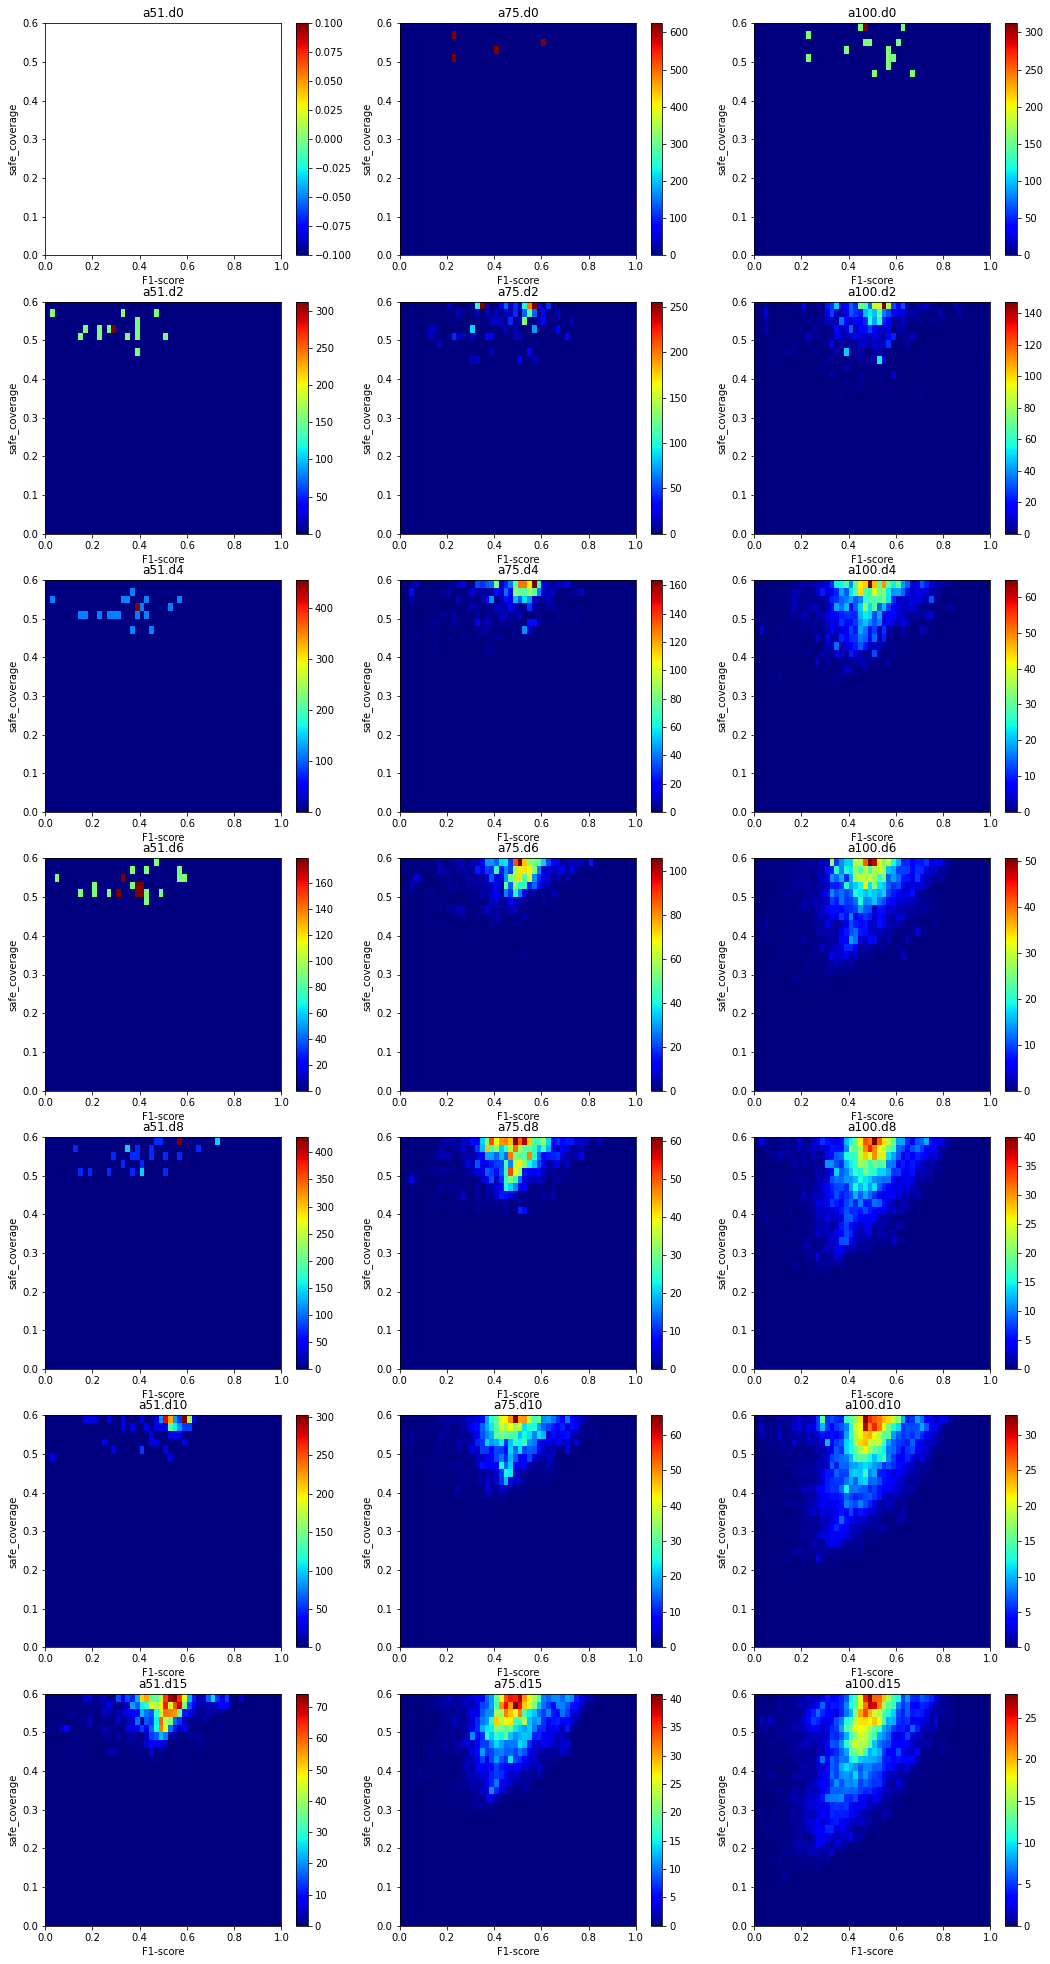

In [88]:
grid_heatmap(groups, "F1-score", "safe_coverage", alphas, deltas, sc_range=[0.0,0.6])

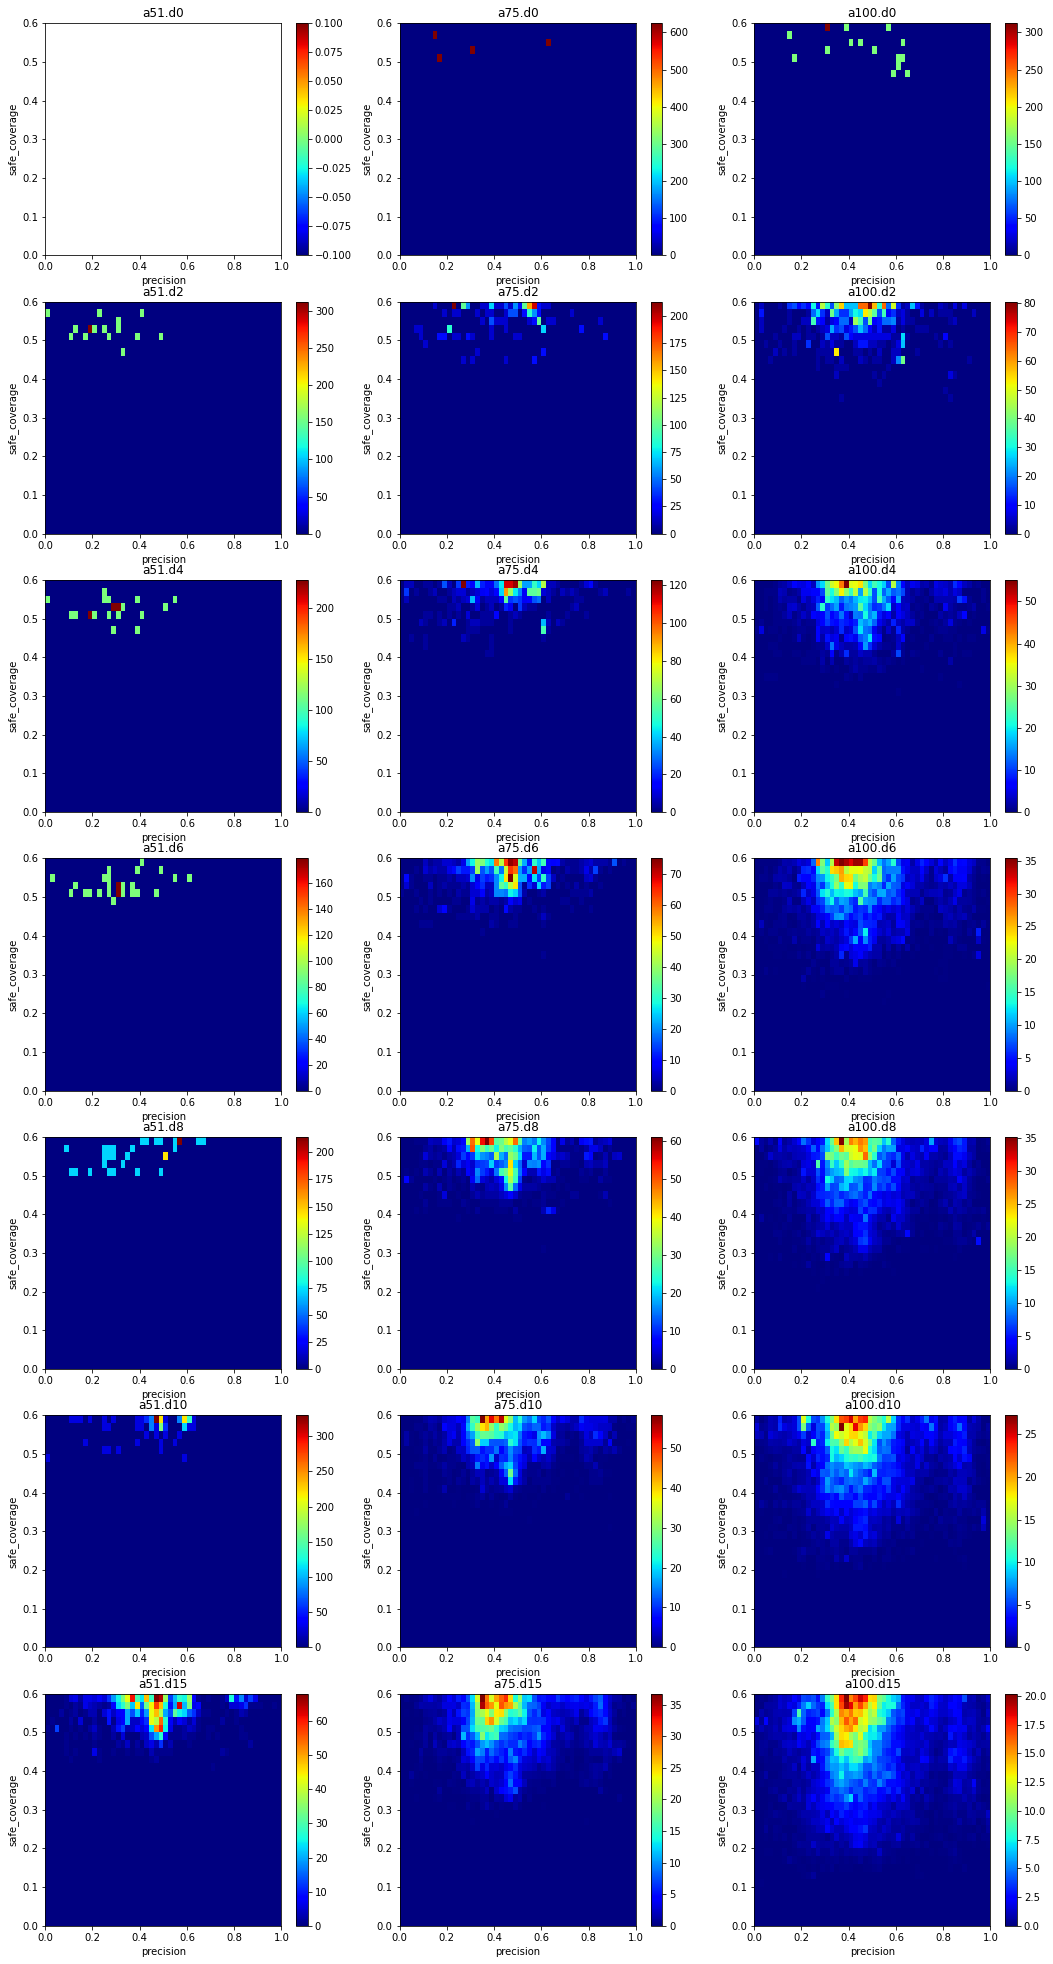

In [89]:
grid_heatmap(groups, "precision", "safe_coverage", alphas, deltas, sc_range=[0.0,0.6])

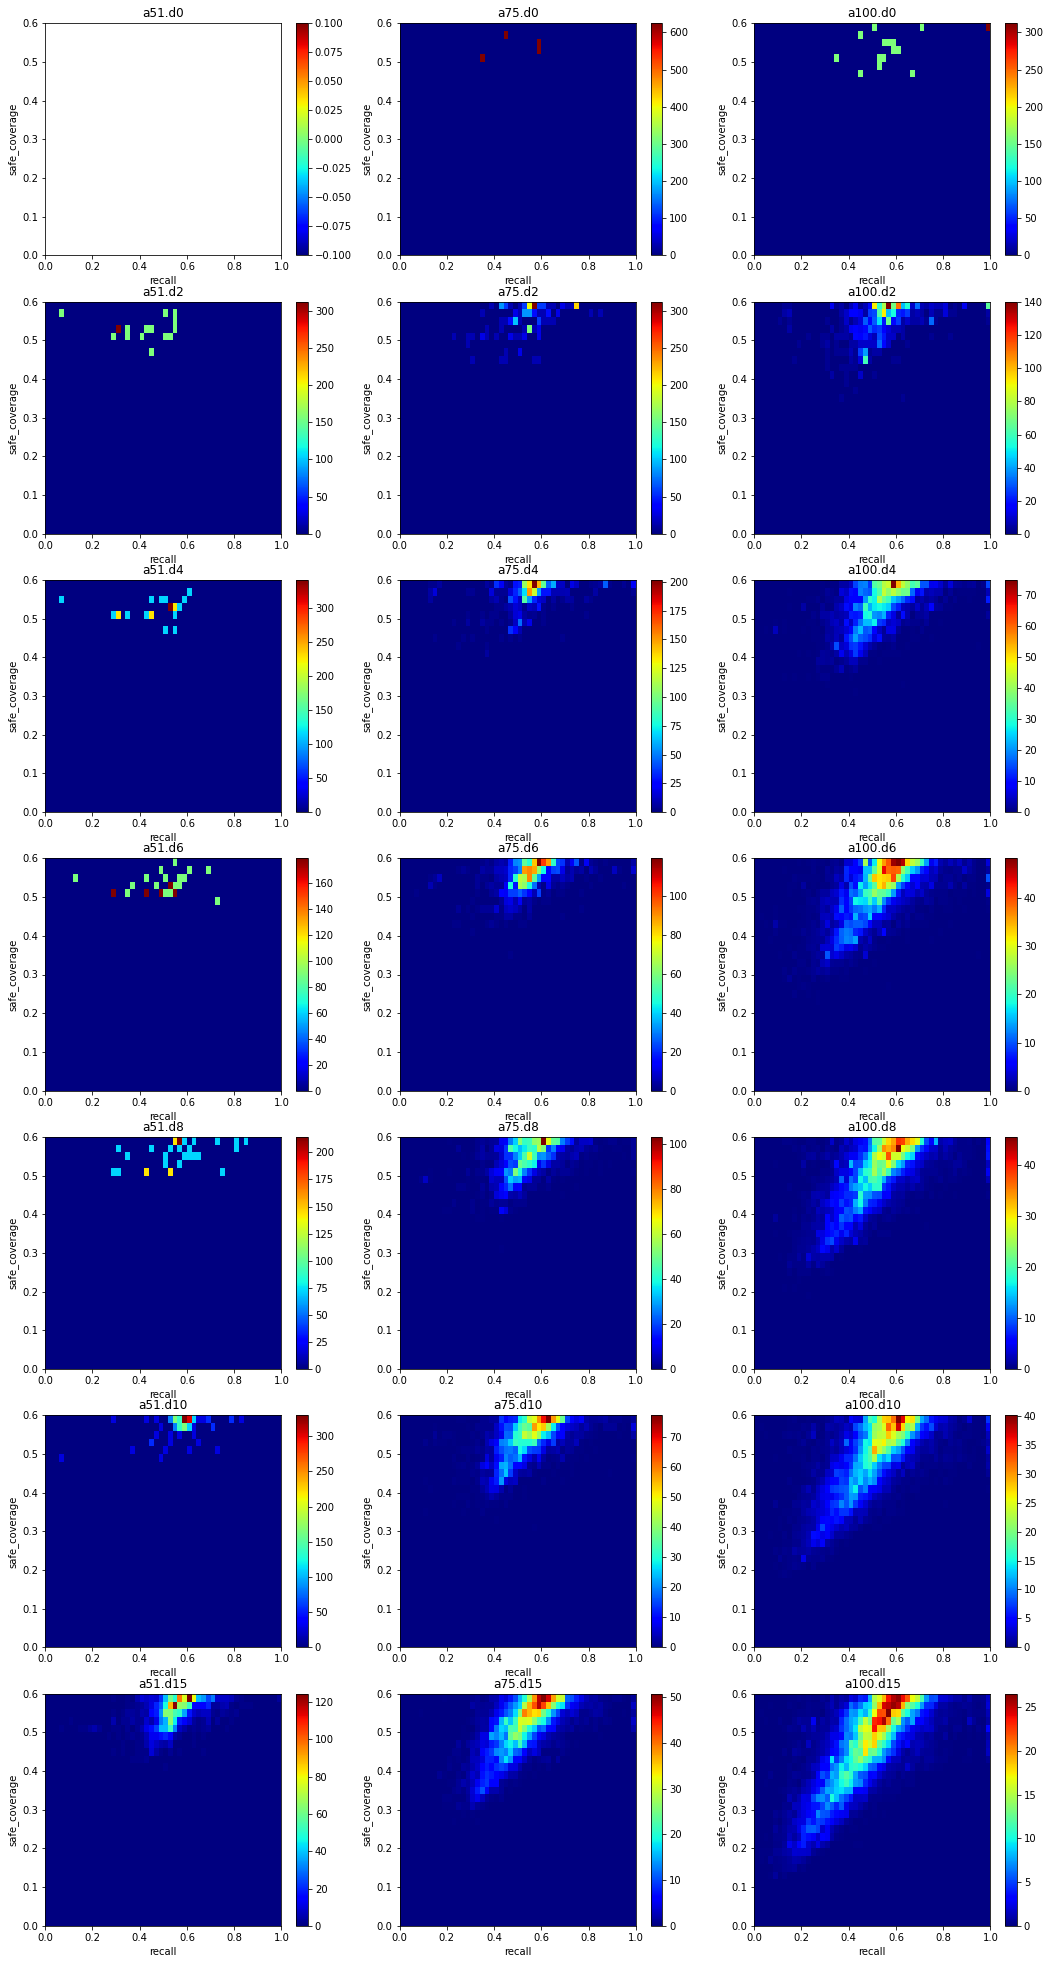

In [90]:
grid_heatmap(groups, "recall", "safe_coverage", alphas, deltas, sc_range=[0.0,0.6])

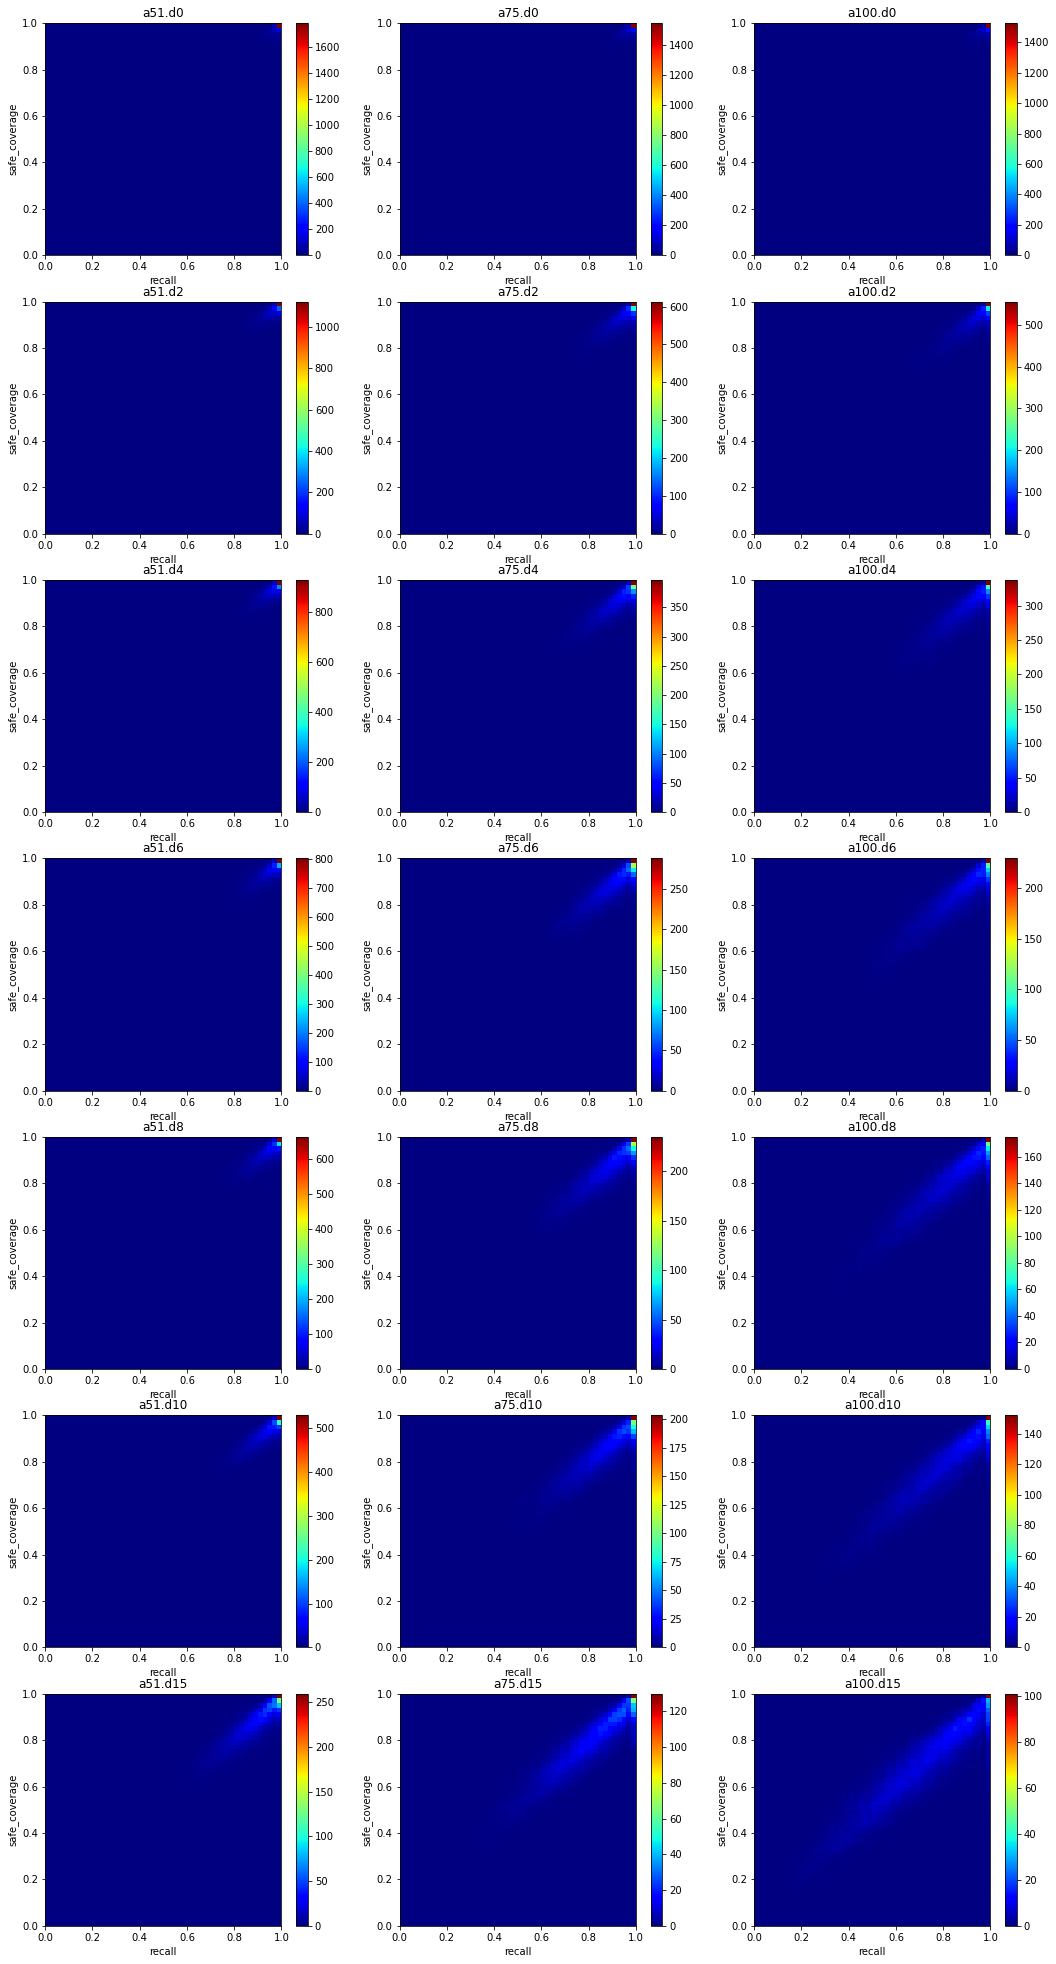

In [95]:
grid_heatmap(groups, "recall", "safe_coverage", alphas, deltas, sc_range=[0.0,1.0])